In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
from functools import reduce
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker
import sys
import os

current_dir = os.getcwd()
module_path = os.path.abspath(os.path.join(current_dir, '..', 'libs'))
if module_path not in sys.path:
    sys.path.append(module_path)

from SCOU_NC_Vanilla_NUTS_manual import *

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
full_data = pd.read_excel("../data/Synthèse pluri annuelle 2021-2024-4.xlsx", sheet_name='Depuis 2021')
full_data.columns = full_data.loc[10]
full_data = full_data.loc[15:]
temp = full_data.columns.tolist()
temp[1] = 'Molecule'
full_data.columns = temp
full_data = full_data.iloc[::, 1:-1]
full_data.Molecule = full_data.Molecule.apply(lambda x: str(x).strip())
full_data

Molecule      LQ      LQ    Unité  \
15     Volume Prétraité Bassins de Clichy     NaN     NaN  m3/jour   
16   Emissaire Genéral Estimation Pompage     NaN     NaN  m3/jour   
17                     Débit Seine Centre     NaN     NaN  m3/jour   
18                            Acénaphtène  0.0093  0.0100     µg/L   
19                               Ammonium     0.3     0.3  mg(N)/L   
..                                    ...     ...     ...      ...   
232                                   nan     NaN     NaN      NaN   
233                                   nan     NaN     NaN      NaN   
234                                   nan     NaN     NaN      NaN   
235                                   nan     NaN     NaN      NaN   
236                                   nan     NaN     NaN      NaN   

    2021-01-01 00:00:00 2021-02-01 00:00:00 2021-03-01 00:00:00  \
15                  NaN                 NaN                 NaN   
16                  NaN                 NaN                 NaN   
17                  NaN                 NaN                 NaN   
18                  NaN                 NaN                 NaN   
19                  NaN                 NaN                 NaN   
..                  ...                 ...                 ...   
232                 NaN                 NaN                 NaN   
233                 NaN                 NaN                 NaN   
234                 NaN                 NaN                 NaN   
235                 NaN                 NaN                 NaN   
236                 NaN                 NaN                 NaN   

    2021-04-01 00:00:00 2021-05-01 00:00:00 2021-06-01 00:00:00  ...  \
15                  NaN                 NaN                 NaN  ...   
16                  NaN                 NaN                 NaN  ...   
17                  NaN                 NaN                 NaN  ...   
18                  NaN                 NaN                 NaN  ...   
19                  NaN                 NaN                 NaN  ...   
..                  ...                 ...                 ...  ...   
232                 NaN                 NaN                 NaN  ...   
233                 NaN                 NaN                 NaN  ...   
234                 NaN                 NaN                 NaN  ...   
235                 NaN                 NaN                 NaN  ...   
236                 NaN                 NaN                 NaN  ...   

    2024-03-19 00:00:00 2024-04-16 00:00:00 2024-05-21 00:00:00  \
15               623460              891400             1023990   
16                  NaN                 NaN                 NaN   
17               232195              270347              273369   
18                 0.01               0.011                0.01   
19                 35.9                27.6                27.9   
..                  ...                 ...                 ...   
232                 NaN                 NaN                 NaN   
233                 NaN                 NaN                 NaN   
234                 NaN                 NaN                 NaN   
235                 NaN                 NaN                 NaN   
236                 NaN                 NaN                 NaN   

    2024-06-18 00:00:00 2024-07-16 00:00:00 2024-08-20 00:00:00  \
15              1065810              720340              782050   
16                  NaN                 NaN                 NaN   
17               330905              215000              213671   
18                 0.01                0.01                0.01   
19                 25.4                32.7                18.2   
..                  ...                 ...                 ...   
232                 NaN                 NaN                 NaN   
233                 NaN                 NaN                 NaN   
234                 NaN                 NaN                 NaN   
235                 NaN                 NaN    

In [3]:
RW2s = {}

In [4]:
mapping_dict = {'janvier': '01', 'février': '02', 'mars': '03', 'avril': '04', 'mai': '05',
                              'juin':'06', 'juillet':'07', 'août':'08', 'septembre':'09', 'octobre':'10', 
                              'novembre':'11', 'décembre':'12'}

In [5]:
volumes_clichy = pd.read_excel("../data/Débit sur Clichy 2021 - 2024.xlsx", sheet_name="Données")
volumes_clichy = volumes_clichy.loc[1:]
volumes_clichy.columns = ['dateStart', 'plantVolume']

volumes_clichy_first_part = volumes_clichy.loc[:1095].copy()
volumes_clichy_second_part = volumes_clichy.loc[1096:].copy()
volumes_clichy_first_part.dateStart = pd.to_datetime(volumes_clichy_first_part.dateStart)

volumes_clichy_second_part['dateStart'] = volumes_clichy_second_part['dateStart'].apply(
    lambda x: reduce(lambda s, kv: s.replace(*kv), mapping_dict.items(), str(x)))

volumes_clichy_second_part.dateStart = volumes_clichy_second_part.dateStart.apply(lambda x: x[:-2] + '2024')

volumes_clichy_second_part.dateStart = volumes_clichy_second_part.dateStart.apply(lambda x: x.split(' ')[1:])

volumes_clichy_second_part.dateStart.apply(lambda x: x.reverse())
volumes_clichy_second_part.dateStart = volumes_clichy_second_part.dateStart.apply(lambda x: '-'.join(x))
volumes_clichy_second_part.dateStart = pd.to_datetime(volumes_clichy_second_part.dateStart)

volumes_clichy.dateStart = volumes_clichy_first_part.dateStart.tolist() + volumes_clichy_second_part.dateStart.tolist()

volumes_clichy.plantVolume = pd.to_numeric(volumes_clichy.plantVolume)
volumes_clichy.set_index('dateStart', inplace=True)

In [7]:
def preprocess_data(molecule, lod):

    sub_data = full_data.loc[full_data.Molecule==molecule].T
    sub_data.reset_index(inplace=True)
    volumes = full_data.loc[full_data.Molecule=='Volume Prétraité Bassins de Clichy'].T
    sub_data = pd.DataFrame(np.hstack((sub_data.values, volumes[15].values.reshape(-1,1))))
    sub_data.columns = ['dateStart', 'obs', 'plantVolume']
    sub_data = sub_data.loc[4:]
    sub_data.dateStart = pd.to_datetime(sub_data.dateStart)
    dropem = sub_data.loc[sub_data.obs==' - '].index.tolist()
    sub_data.drop(dropem, axis=0, inplace=True)
    sub_data.obs.replace('ND', 0, inplace=True)
    sub_data.obs.replace(0, 1, inplace=True)
    sub_data.obs = pd.to_numeric(sub_data.obs)
    sub_data.loc[sub_data.obs<=lod, 'obs'] = lod
    sub_data.plantVolume = pd.to_numeric(sub_data.plantVolume)
    sub_data.loc[sub_data.dateStart=='2021-04-01', 'plantVolume'] = 691250
        
    sub_data = sub_data.loc[~sub_data.obs.isna()]

    sub_data.plantVolume *= 1000
    sub_data['Raw_lod'] = lod
    sub_data['Raw_concentration'] = sub_data.obs.values
    sub_data['obs'] = sub_data['Raw_concentration'] * sub_data['plantVolume']
    sub_data['lod'] = sub_data['Raw_lod'] * sub_data['plantVolume']
    sub_data.obs = np.log(sub_data.obs)
    sub_data.lod = np.log(sub_data.lod)

    sub_data.drop('plantVolume', axis=1, inplace=True)
    
    sub_data.set_index('dateStart', inplace=True)
    sub_data = sub_data.join(volumes_clichy['plantVolume'])
    sub_data.reset_index(inplace=True)
    sub_data.plantVolume *= 1000
    
    sub_data = sub_data.set_index('dateStart').resample('D').mean().reset_index()

    return sub_data

In [8]:
this_molecule = 'Crassphage'
this_lod = 4500
this_lod

4500

In [9]:
sub_data = preprocess_data(this_molecule, this_lod)

In [10]:
sub_data.loc[sub_data.obs <= sub_data.lod]

Empty DataFrame
Columns: [dateStart, obs, Raw_lod, Raw_concentration, lod, plantVolume]
Index: []

In [14]:
lod_matrix = sub_data.lod.values
observation_matrix = sub_data.obs.values

filename = 'discard.nc'
tuning_iters = 12000
sampling_iters = 2000
nb_chains = 15

snc_ar1_nuts = SCOU_RW1_NUTS(observation_matrix, lod_matrix, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=filename, 
                             p_out_frozen=-1, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
snc_ar1_nuts.fit()

# Done
notify_mac("Jupyter", "Work done !")

/opt/anaconda3/envs/pymc5/lib/python3.9/site-packages/pymc/distributions/timeseries.py:558: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (15 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 15 chains for 12_000 tune and 2_000 draw iterations (180_000 + 30_000 draws total) took 4159 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 6 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 8 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 11 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 12 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameter

Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.289  0.462   0.054    1.001      0.105    0.076      22.0      22.0   
eps    0.559  1.494   0.105    1.109      0.064    0.045     113.0     114.0   
p_out  0.348  0.336   0.056    0.944      0.085    0.062      27.0     116.0   

       r_hat  
sig     1.84  
eps     1.11  
p_out   1.51  


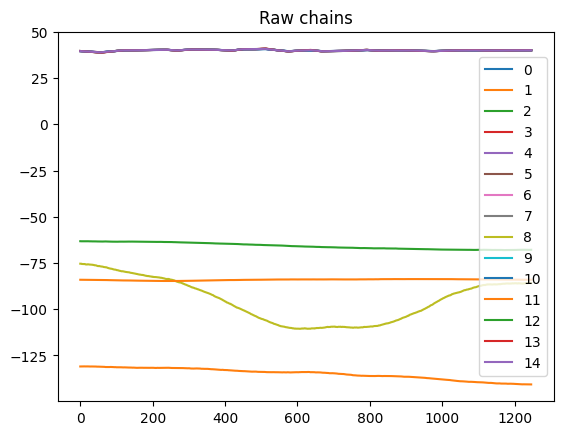

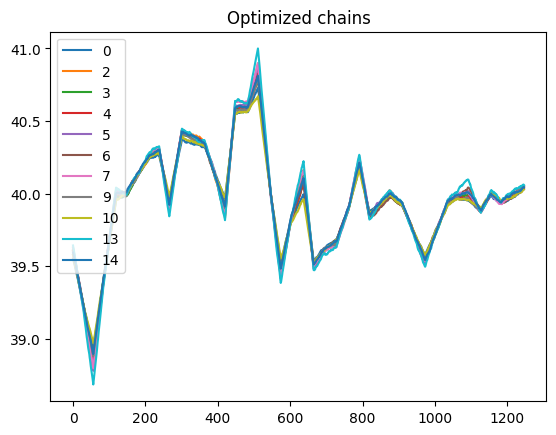

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.110  0.027   0.063    0.158      0.004    0.003      55.0     181.0   
eps    0.396  0.124   0.173    0.629      0.003    0.002    1723.0    6749.0   
p_out  0.149  0.062   0.046    0.268      0.001    0.000    7938.0   12723.0   

       r_hat  
sig     1.17  
eps     1.01  
p_out   1.00  


In [19]:
selected_chains = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
remove_those = [1, 11, 8, 12]
for i in remove_those:
    selected_chains.remove(i)


snc_ar1_nuts.visualize_latents(selected_chains)
snc_ar1_nuts.predict(selected_chains)

In [20]:
sub_data['muX'] = snc_ar1_nuts.muX
sub_data['ICL'] = snc_ar1_nuts.CIL
sub_data['ICU'] = snc_ar1_nuts.CIU
sub_data['pout'] = snc_ar1_nuts.pointwise_pout

sub_data.obs = np.log10(np.exp(sub_data.obs))
sub_data.muX = np.log10(np.exp(sub_data.muX))
sub_data.ICL = np.log10(np.exp(sub_data.ICL))
sub_data.ICU = np.log10(np.exp(sub_data.ICU))

RW2s[this_molecule] = sub_data.copy()

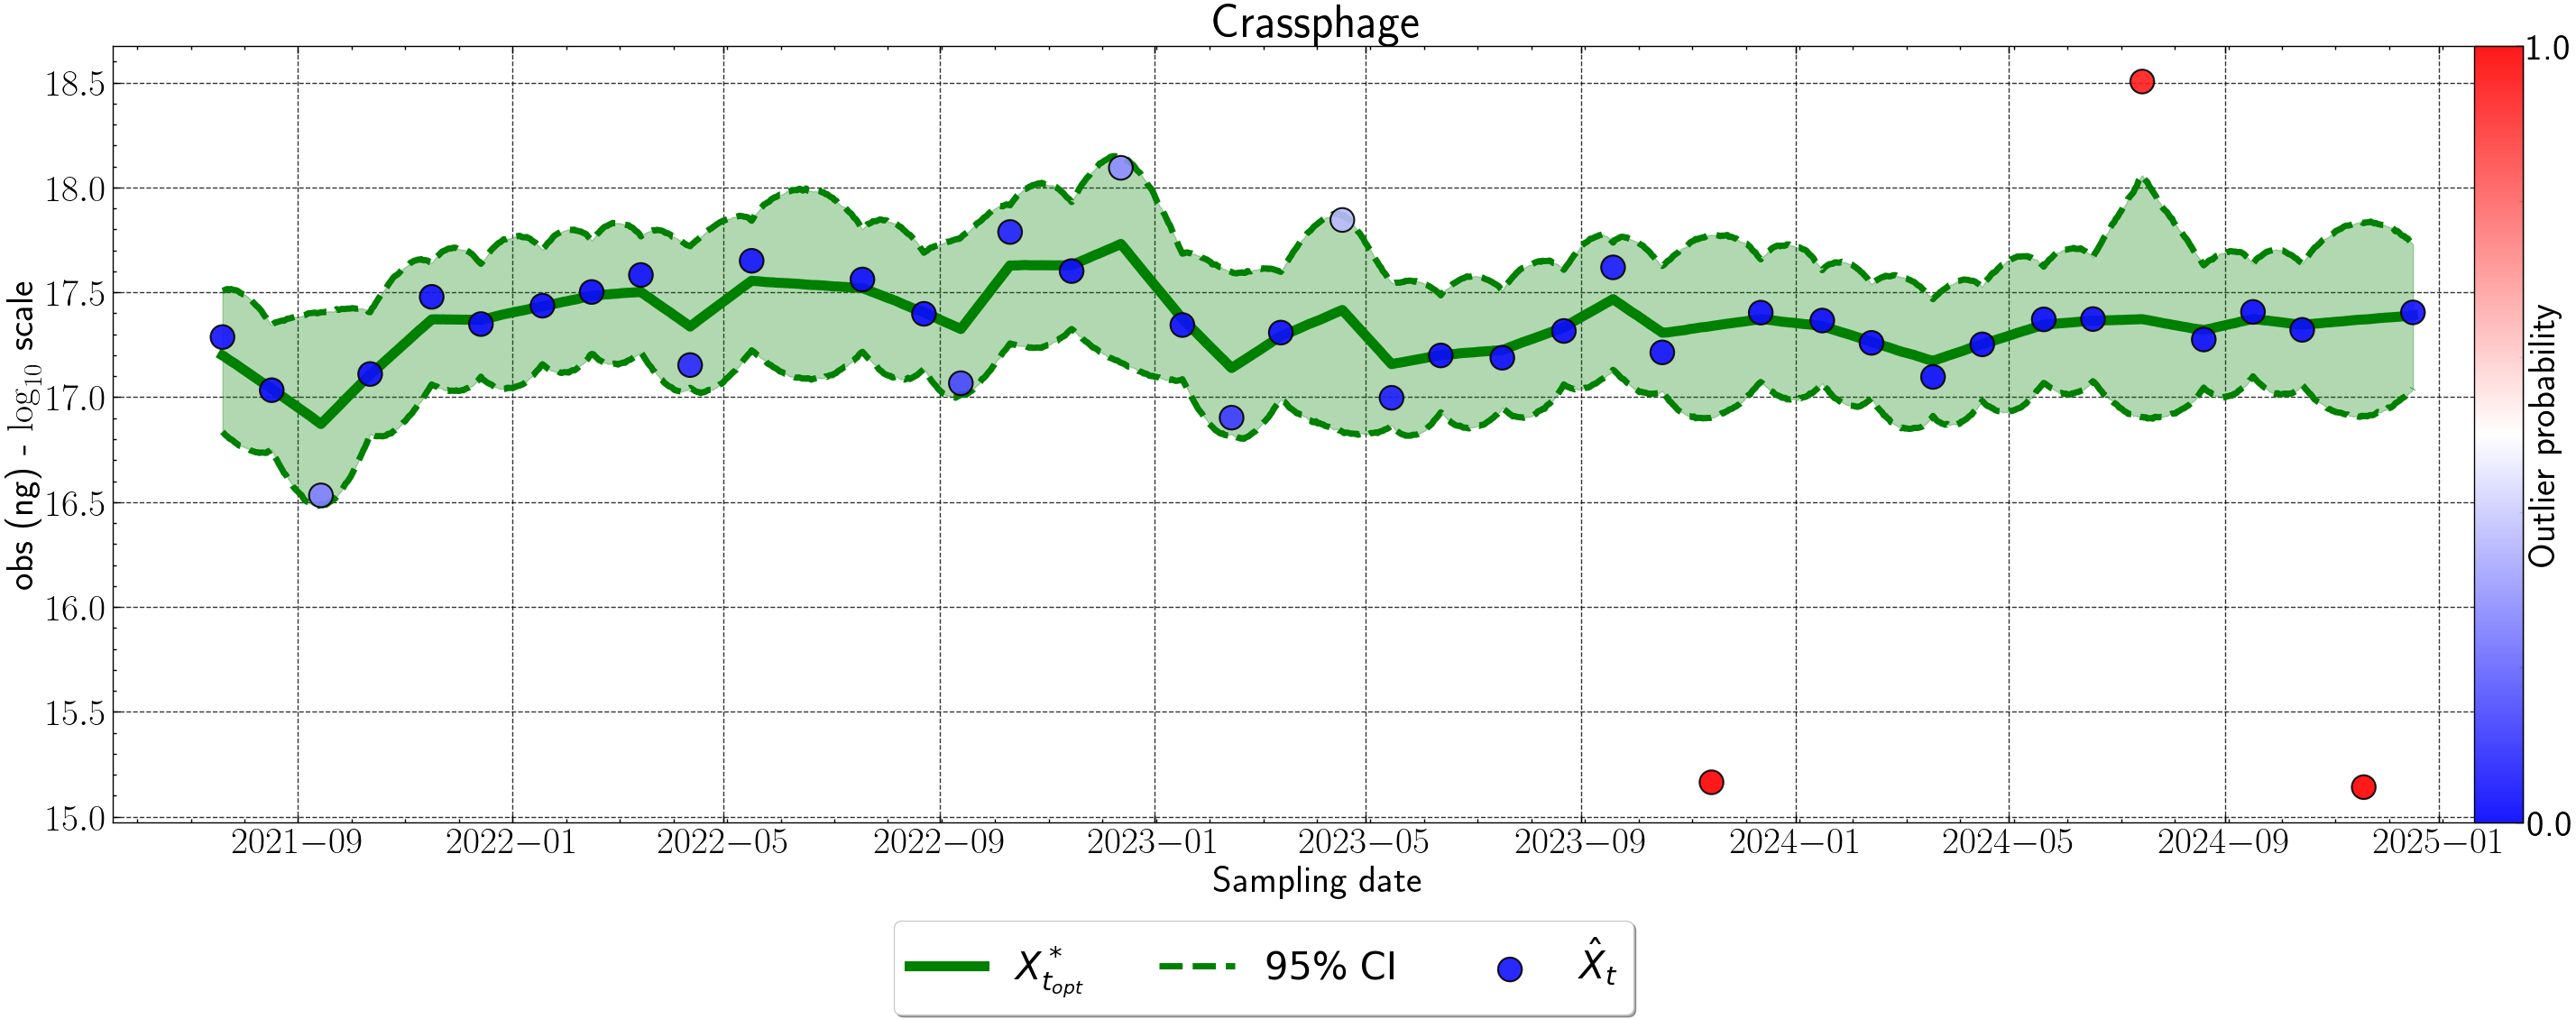

In [21]:
with plt.style.context(['science', 'notebook', 'grid']):

    LABEL_SIZE = 30
    TICK_SIZE = 30
    TITLE_SIZE = 38
    LEGEND_SIZE = 30
    DATES_SIZE = 18
    figsize = (28, 10) #figsize = (32, 10)
    
    plt.rc('axes', labelsize=LABEL_SIZE)
    plt.rc('xtick', labelsize=TICK_SIZE)   
    plt.rc('ytick', labelsize=TICK_SIZE)
    plt.rc('figure', titlesize=TITLE_SIZE)
    plt.rc('legend', fontsize=LEGEND_SIZE)
    plt.rcParams['text.usetex'] = True
    
    fig = plt.figure(figsize=figsize, layout="constrained")
    
    ax_dict = fig.subplot_mosaic(
        """
        A
        """
    )
    
    ### A
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.muX.values, label='$X^*_{t_{opt}}$', color='green', linewidth=8, zorder=3)
    
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICL.values, label='95% CI', linestyle='--', color='green', linewidth=5, zorder=1)
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICU.values, linestyle='--', color='green', linewidth=5, zorder=1)
    
    ax_dict['A'].fill_between(sub_data.dateStart.values, sub_data.ICL.values, sub_data.ICU.values, alpha=.3, color='green')

    
    scatter_points = ax_dict['A'].scatter(sub_data.dateStart.values, sub_data.obs.values, label='$\hat{X}_t$', 
                         c=sub_data.pout.values,
                         cmap='bwr', edgecolor='black', s=360, zorder=3,
                         linewidths=1.5, alpha=0.9, vmin=0, vmax=1)

    
    ax_dict['A'].set_ylabel("obs (ng) - $\log_{10}$ scale")
    ax_dict['A'].set_xlabel("Sampling date")
    ax_dict['A'].tick_params(axis='x', labelsize=TICK_SIZE)
    ax_dict['A'].tick_params(axis='y', labelsize=TICK_SIZE)
    ax_dict['A'].grid(linewidth=1, color='black', alpha=0.8)
    ax_dict['A'].set_title(this_molecule, size=TITLE_SIZE)

    ### Outlier probability legend:
    cmin, cmax = 0.0, 1.0 
    axins1 = inset_axes(ax_dict['A'], width='2%', height='100%', loc='right', borderpad=0)
    axins1.grid(False)
    cbar = fig.colorbar(scatter_points, cax=axins1, orientation='vertical')
    
    # Setting tick limits:
    cbar.set_ticks([cmin, cmax])
    cbar.ax.yaxis.set_major_locator(ticker.FixedLocator([cmin, cmax]))
    
    # Standardizing the float format displayed:
    decimal_places = 1
    cbar.ax.set_yticklabels([f"{cmin:.{decimal_places}f}", f"{cmax:.{decimal_places}f}"], fontsize=TICK_SIZE)

    # Placing the label at the right spot:
    cbar.ax.set_ylabel('Outlier probability', size=TICK_SIZE, labelpad=-35)

    # Main legend
    plt.rcParams['text.usetex'] = False
    h1, l1 = ax_dict['A'].get_legend_handles_labels()
    fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=5)
    
    plt.show()

In [22]:
### Pout estimé par le SCOU NUTS

In [23]:
for molecule in list(RW2s.keys()):
    this_file = RW2s[molecule]
    this_file.to_csv('../outputs/files/viral_data_manuscript/' + molecule + '.csv', sep=';', index=False)

In [24]:
this_molecule = 'PMMoV (Pepper mild mottle virus)'
this_lod = 4500
this_lod

4500

In [25]:
sub_data = preprocess_data(this_molecule, this_lod)

In [26]:
sub_data.loc[sub_data.obs <= sub_data.lod]

Empty DataFrame
Columns: [dateStart, obs, Raw_lod, Raw_concentration, lod, plantVolume]
Index: []

In [27]:
lod_matrix = sub_data.lod.values
observation_matrix = sub_data.obs.values

filename = 'discard.nc'
tuning_iters = 12000
sampling_iters = 2000
nb_chains = 15

snc_ar1_nuts = SCOU_RW1_NUTS(observation_matrix, lod_matrix, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=filename, 
                             p_out_frozen=-1, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
snc_ar1_nuts.fit()

# Done
notify_mac("Jupyter", "Work done !")

/opt/anaconda3/envs/pymc5/lib/python3.9/site-packages/pymc/distributions/timeseries.py:558: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (15 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 15 chains for 12_000 tune and 2_000 draw iterations (180_000 + 30_000 draws total) took 3844 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.209  0.263   0.058    0.588      0.063    0.045      30.0      19.0   
eps    0.558  0.334   0.172    0.908      0.021    0.015     273.0     221.0   
p_out  0.161  0.188   0.003    0.388      0.043    0.032      61.0      18.0   

       r_hat  
sig     1.46  
eps     1.04  
p_out   1.16  


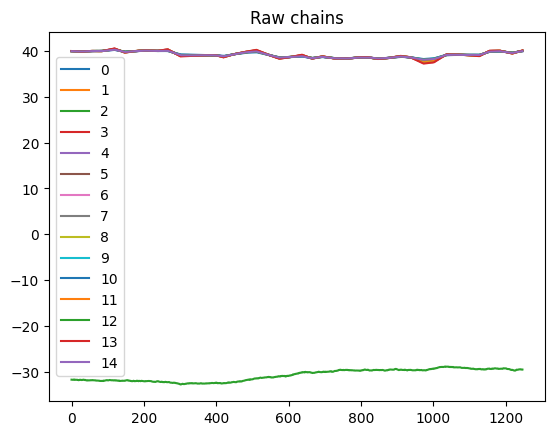

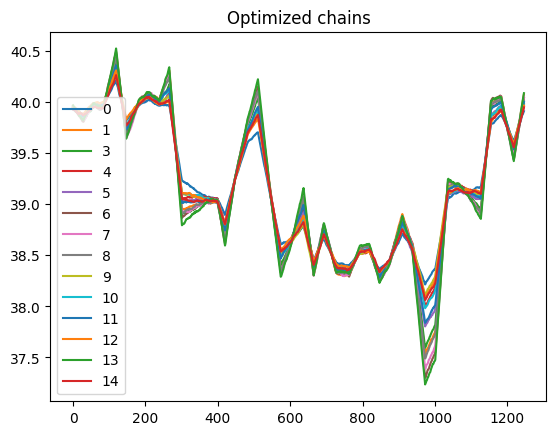

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.146  0.040   0.078    0.219      0.006    0.004      46.0     228.0   
eps    0.538  0.195   0.191    0.890      0.012    0.008     274.0    4062.0   
p_out  0.117  0.073   0.005    0.250      0.001    0.001    4428.0   16396.0   

       r_hat  
sig     1.24  
eps     1.04  
p_out   1.01  


In [32]:
selected_chains = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
remove_those = [2]
for i in remove_those:
    selected_chains.remove(i)


snc_ar1_nuts.visualize_latents(selected_chains)
snc_ar1_nuts.predict(selected_chains)

In [33]:
sub_data['muX'] = snc_ar1_nuts.muX
sub_data['ICL'] = snc_ar1_nuts.CIL
sub_data['ICU'] = snc_ar1_nuts.CIU
sub_data['pout'] = snc_ar1_nuts.pointwise_pout

sub_data.obs = np.log10(np.exp(sub_data.obs))
sub_data.muX = np.log10(np.exp(sub_data.muX))
sub_data.ICL = np.log10(np.exp(sub_data.ICL))
sub_data.ICU = np.log10(np.exp(sub_data.ICU))

RW2s[this_molecule] = sub_data.copy()

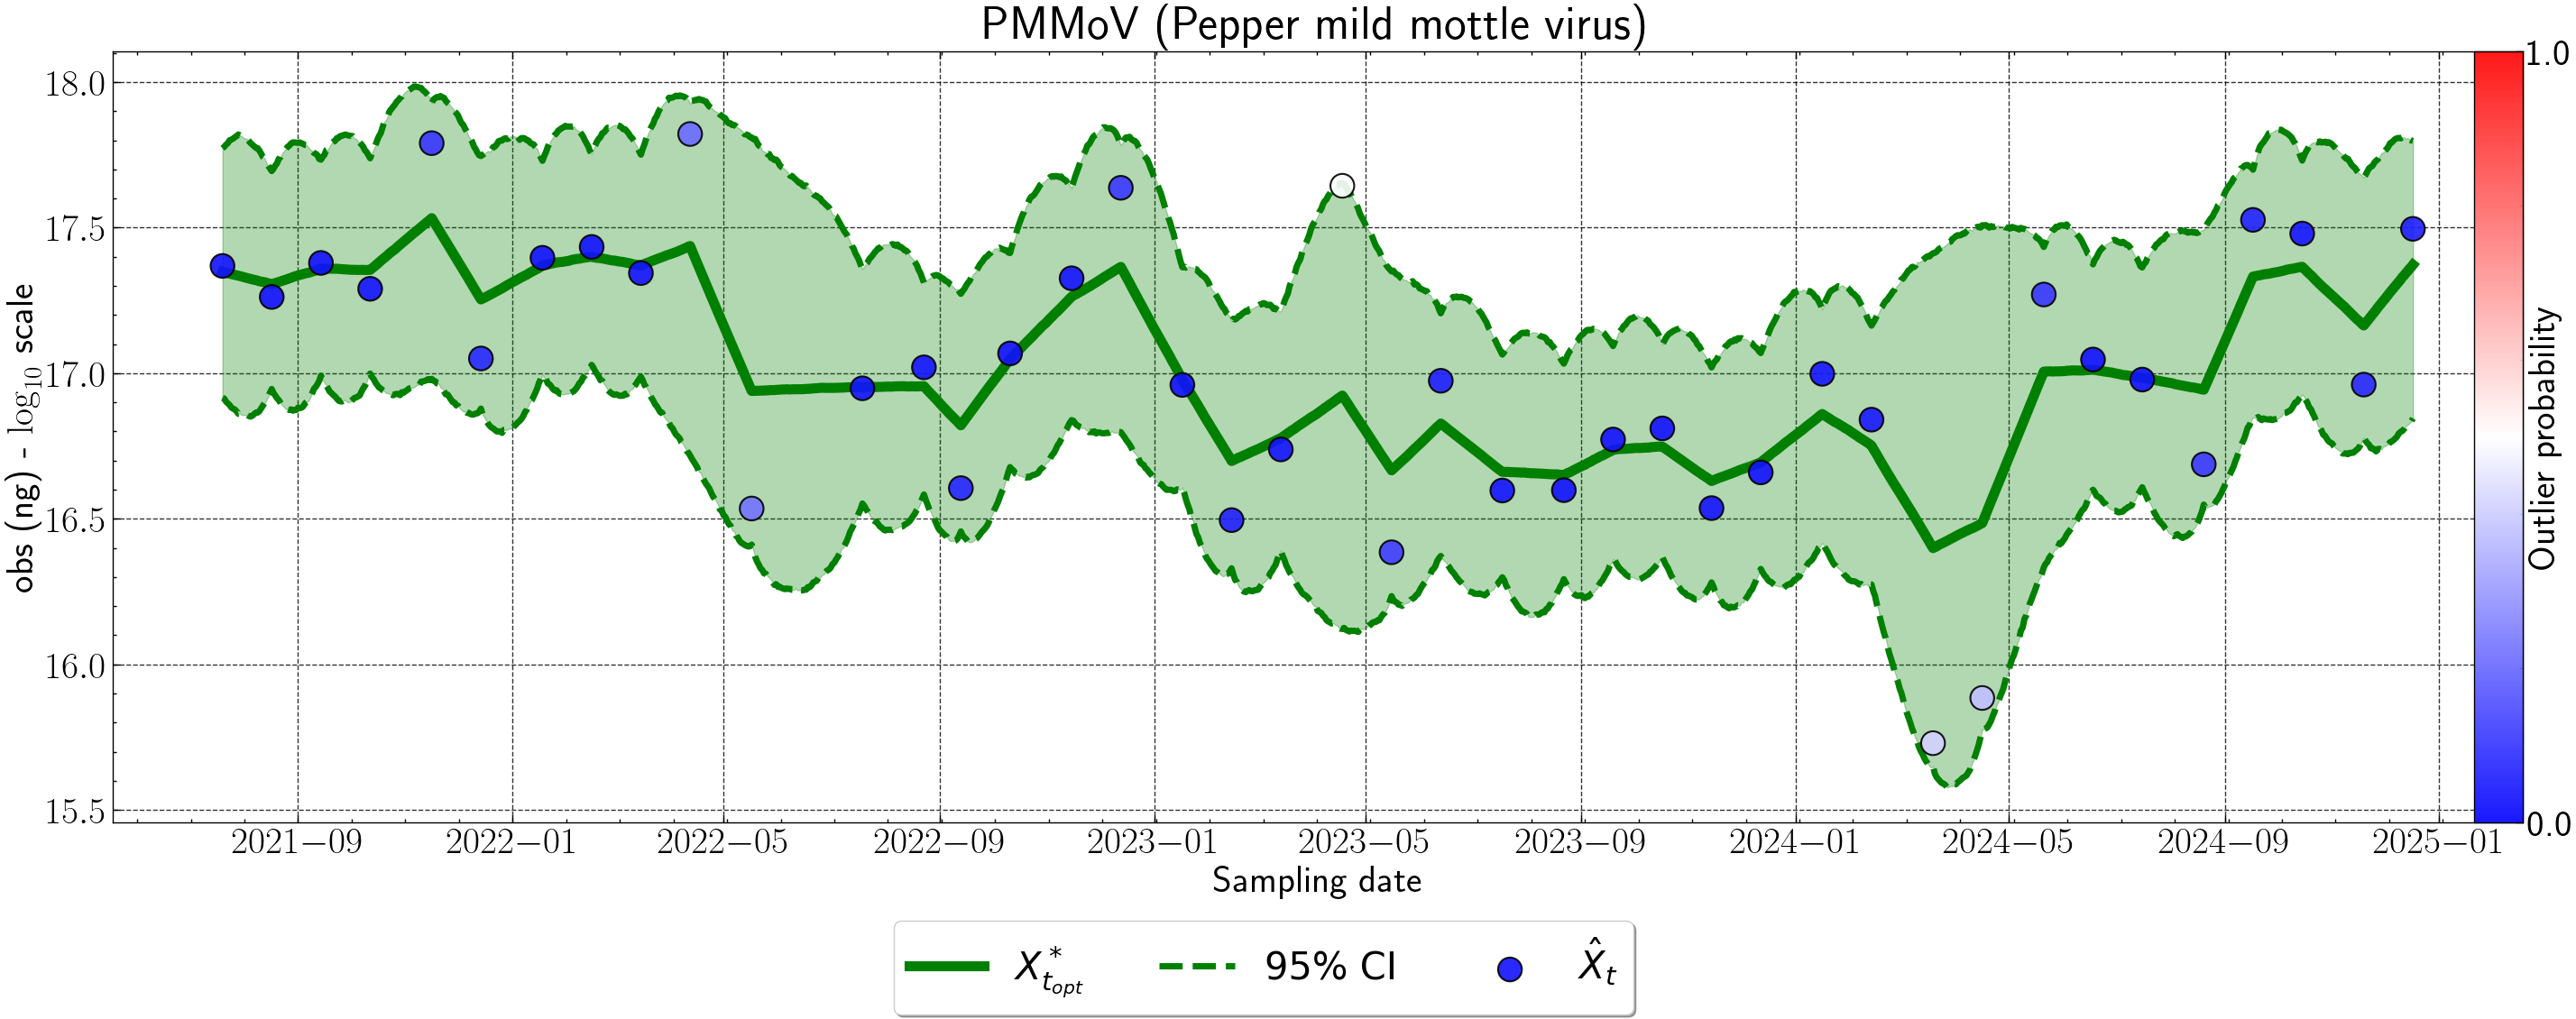

In [34]:
with plt.style.context(['science', 'notebook', 'grid']):

    LABEL_SIZE = 30
    TICK_SIZE = 30
    TITLE_SIZE = 38
    LEGEND_SIZE = 30
    DATES_SIZE = 18
    figsize = (28, 10) #figsize = (32, 10)
    
    plt.rc('axes', labelsize=LABEL_SIZE)
    plt.rc('xtick', labelsize=TICK_SIZE)   
    plt.rc('ytick', labelsize=TICK_SIZE)
    plt.rc('figure', titlesize=TITLE_SIZE)
    plt.rc('legend', fontsize=LEGEND_SIZE)
    plt.rcParams['text.usetex'] = True
    
    fig = plt.figure(figsize=figsize, layout="constrained")
    
    ax_dict = fig.subplot_mosaic(
        """
        A
        """
    )
    
    ### A
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.muX.values, label='$X^*_{t_{opt}}$', color='green', linewidth=8, zorder=3)
    
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICL.values, label='95% CI', linestyle='--', color='green', linewidth=5, zorder=1)
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICU.values, linestyle='--', color='green', linewidth=5, zorder=1)
    
    ax_dict['A'].fill_between(sub_data.dateStart.values, sub_data.ICL.values, sub_data.ICU.values, alpha=.3, color='green')

    
    scatter_points = ax_dict['A'].scatter(sub_data.dateStart.values, sub_data.obs.values, label='$\hat{X}_t$', 
                         c=sub_data.pout.values,
                         cmap='bwr', edgecolor='black', s=360, zorder=3,
                         linewidths=1.5, alpha=0.9, vmin=0, vmax=1)

    
    ax_dict['A'].set_ylabel("obs (ng) - $\log_{10}$ scale")
    ax_dict['A'].set_xlabel("Sampling date")
    ax_dict['A'].tick_params(axis='x', labelsize=TICK_SIZE)
    ax_dict['A'].tick_params(axis='y', labelsize=TICK_SIZE)
    ax_dict['A'].grid(linewidth=1, color='black', alpha=0.8)
    ax_dict['A'].set_title(this_molecule, size=TITLE_SIZE)

    ### Outlier probability legend:
    cmin, cmax = 0.0, 1.0 
    axins1 = inset_axes(ax_dict['A'], width='2%', height='100%', loc='right', borderpad=0)
    axins1.grid(False)
    cbar = fig.colorbar(scatter_points, cax=axins1, orientation='vertical')
    
    # Setting tick limits:
    cbar.set_ticks([cmin, cmax])
    cbar.ax.yaxis.set_major_locator(ticker.FixedLocator([cmin, cmax]))
    
    # Standardizing the float format displayed:
    decimal_places = 1
    cbar.ax.set_yticklabels([f"{cmin:.{decimal_places}f}", f"{cmax:.{decimal_places}f}"], fontsize=TICK_SIZE)

    # Placing the label at the right spot:
    cbar.ax.set_ylabel('Outlier probability', size=TICK_SIZE, labelpad=-35)

    # Main legend
    plt.rcParams['text.usetex'] = False
    h1, l1 = ax_dict['A'].get_legend_handles_labels()
    fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=5)
    
    plt.show()

In [35]:
### Pout estimé par le SCOU NUTS

In [36]:
for molecule in list(RW2s.keys()):
    this_file = RW2s[molecule]
    this_file.to_csv('../outputs/files/viral_data_manuscript/' + molecule + '.csv', sep=';', index=False)

In [14]:
this_molecule = 'Norovirus-GI'
this_lod = 4500
this_lod

4500

In [15]:
sub_data = preprocess_data(this_molecule, this_lod)

In [16]:
sub_data.loc[sub_data.obs <= sub_data.lod]

Empty DataFrame
Columns: [dateStart, obs, Raw_lod, Raw_concentration, lod, plantVolume]
Index: []

In [17]:
lod_matrix = sub_data.lod.values
observation_matrix = sub_data.obs.values

filename = 'discard.nc'
tuning_iters = 12000
sampling_iters = 2000
nb_chains = 15

snc_ar1_nuts = SCOU_RW1_NUTS(observation_matrix, lod_matrix, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=filename, 
                             p_out_frozen=-1, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
snc_ar1_nuts.fit()

# Done
notify_mac("Jupyter", "Work done !")

/opt/anaconda3/envs/pymc5/lib/python3.9/site-packages/pymc/distributions/timeseries.py:558: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (15 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 15 chains for 12_000 tune and 2_000 draw iterations (180_000 + 30_000 draws total) took 3616 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.143  0.035   0.083    0.207      0.003    0.002     124.0     229.0   
eps    0.507  0.202   0.159    0.858      0.005    0.004    1770.0    6996.0   
p_out  0.136  0.080   0.008    0.279      0.001    0.001    7150.0   17753.0   

       r_hat  
sig     1.09  
eps     1.01  
p_out   1.00  


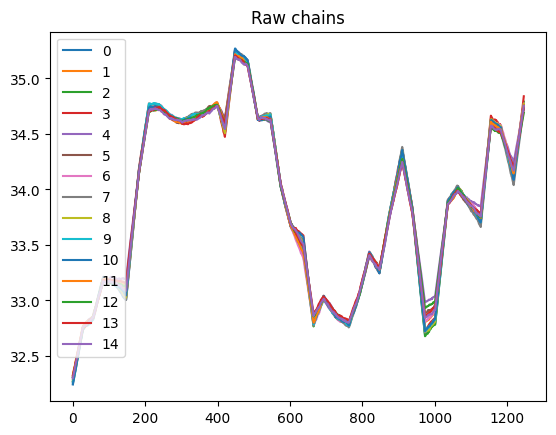

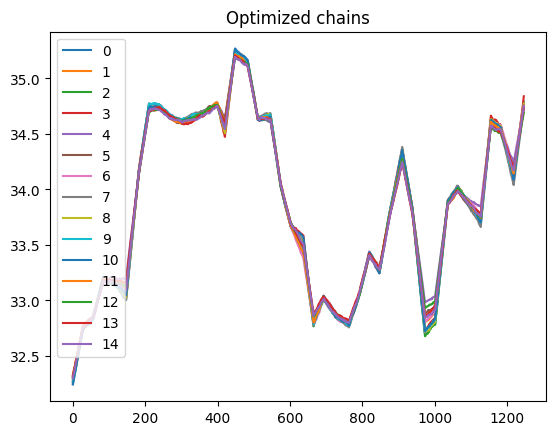

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.143  0.035   0.083    0.207      0.003    0.002     124.0     229.0   
eps    0.507  0.202   0.159    0.858      0.005    0.004    1770.0    6996.0   
p_out  0.136  0.080   0.008    0.279      0.001    0.001    7150.0   17753.0   

       r_hat  
sig     1.09  
eps     1.01  
p_out   1.00  


In [19]:
selected_chains = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
remove_those = []
for i in remove_those:
    selected_chains.remove(i)


snc_ar1_nuts.visualize_latents(selected_chains)
snc_ar1_nuts.predict(selected_chains)

In [20]:
sub_data['muX'] = snc_ar1_nuts.muX
sub_data['ICL'] = snc_ar1_nuts.CIL
sub_data['ICU'] = snc_ar1_nuts.CIU
sub_data['pout'] = snc_ar1_nuts.pointwise_pout

sub_data.obs = np.log10(np.exp(sub_data.obs))
sub_data.muX = np.log10(np.exp(sub_data.muX))
sub_data.ICL = np.log10(np.exp(sub_data.ICL))
sub_data.ICU = np.log10(np.exp(sub_data.ICU))

RW2s[this_molecule] = sub_data.copy()

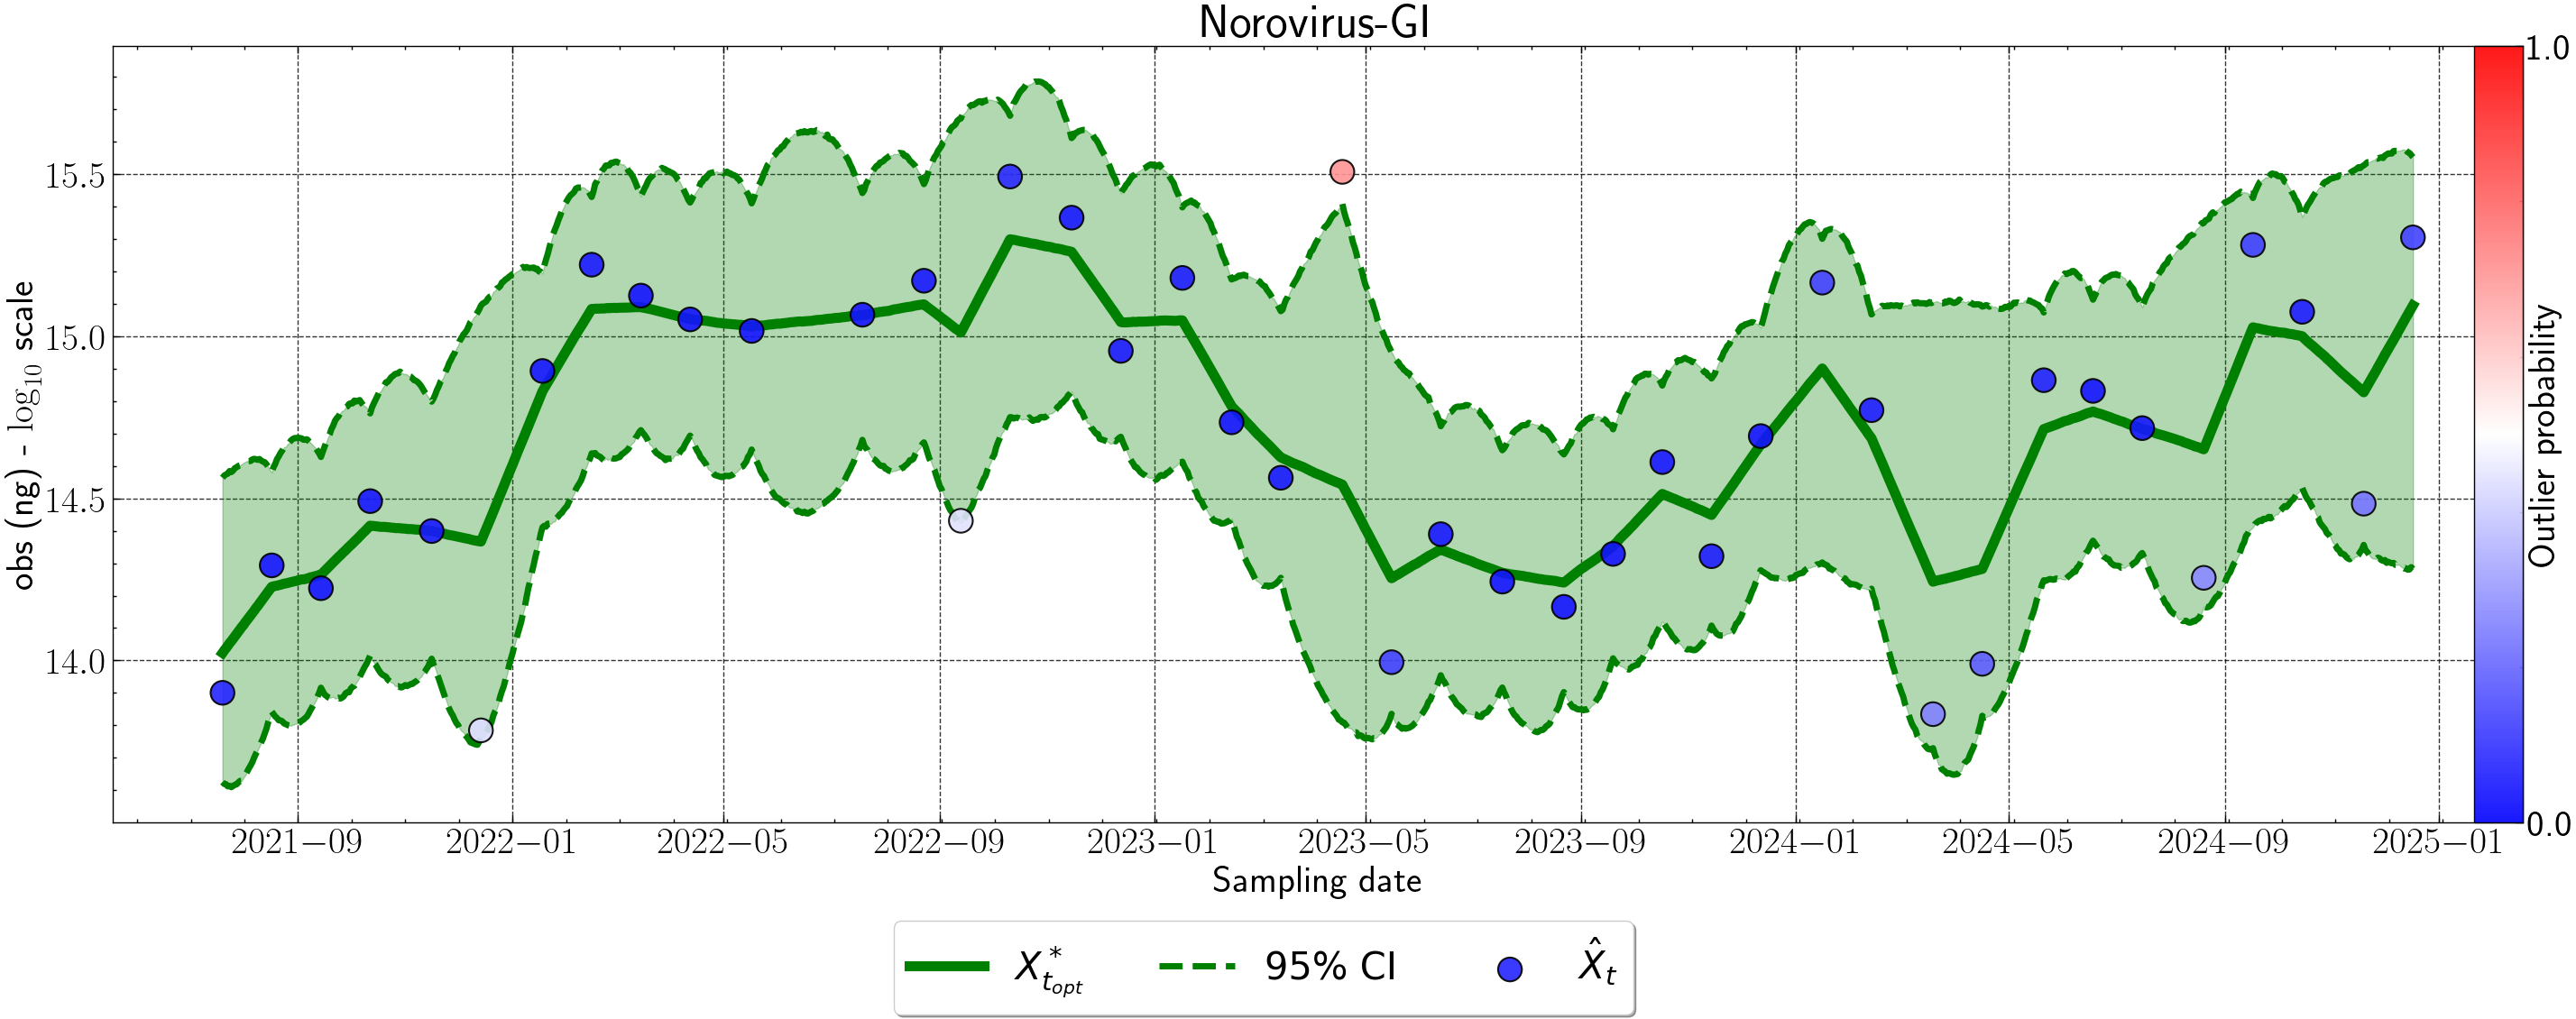

In [21]:
with plt.style.context(['science', 'notebook', 'grid']):

    LABEL_SIZE = 30
    TICK_SIZE = 30
    TITLE_SIZE = 38
    LEGEND_SIZE = 30
    DATES_SIZE = 18
    figsize = (28, 10) #figsize = (32, 10)
    
    plt.rc('axes', labelsize=LABEL_SIZE)
    plt.rc('xtick', labelsize=TICK_SIZE)   
    plt.rc('ytick', labelsize=TICK_SIZE)
    plt.rc('figure', titlesize=TITLE_SIZE)
    plt.rc('legend', fontsize=LEGEND_SIZE)
    plt.rcParams['text.usetex'] = True
    
    fig = plt.figure(figsize=figsize, layout="constrained")
    
    ax_dict = fig.subplot_mosaic(
        """
        A
        """
    )
    
    ### A
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.muX.values, label='$X^*_{t_{opt}}$', color='green', linewidth=8, zorder=3)
    
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICL.values, label='95% CI', linestyle='--', color='green', linewidth=5, zorder=1)
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICU.values, linestyle='--', color='green', linewidth=5, zorder=1)
    
    ax_dict['A'].fill_between(sub_data.dateStart.values, sub_data.ICL.values, sub_data.ICU.values, alpha=.3, color='green')

    
    scatter_points = ax_dict['A'].scatter(sub_data.dateStart.values, sub_data.obs.values, label='$\hat{X}_t$', 
                         c=sub_data.pout.values,
                         cmap='bwr', edgecolor='black', s=360, zorder=3,
                         linewidths=1.5, alpha=0.9, vmin=0, vmax=1)

    
    ax_dict['A'].set_ylabel("obs (ng) - $\log_{10}$ scale")
    ax_dict['A'].set_xlabel("Sampling date")
    ax_dict['A'].tick_params(axis='x', labelsize=TICK_SIZE)
    ax_dict['A'].tick_params(axis='y', labelsize=TICK_SIZE)
    ax_dict['A'].grid(linewidth=1, color='black', alpha=0.8)
    ax_dict['A'].set_title(this_molecule, size=TITLE_SIZE)

    ### Outlier probability legend:
    cmin, cmax = 0.0, 1.0 
    axins1 = inset_axes(ax_dict['A'], width='2%', height='100%', loc='right', borderpad=0)
    axins1.grid(False)
    cbar = fig.colorbar(scatter_points, cax=axins1, orientation='vertical')
    
    # Setting tick limits:
    cbar.set_ticks([cmin, cmax])
    cbar.ax.yaxis.set_major_locator(ticker.FixedLocator([cmin, cmax]))
    
    # Standardizing the float format displayed:
    decimal_places = 1
    cbar.ax.set_yticklabels([f"{cmin:.{decimal_places}f}", f"{cmax:.{decimal_places}f}"], fontsize=TICK_SIZE)

    # Placing the label at the right spot:
    cbar.ax.set_ylabel('Outlier probability', size=TICK_SIZE, labelpad=-35)

    # Main legend
    plt.rcParams['text.usetex'] = False
    h1, l1 = ax_dict['A'].get_legend_handles_labels()
    fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=5)
    
    plt.show()

In [22]:
### Pout estimé par le SCOU NUTS

In [23]:
for molecule in list(RW2s.keys()):
    this_file = RW2s[molecule]
    this_file.to_csv('../outputs/files/viral_data_manuscript/' + molecule + '.csv', sep=';', index=False)

In [24]:
this_molecule = 'Norovirus-GII'
this_lod = 4500
this_lod

4500

In [25]:
sub_data = preprocess_data(this_molecule, this_lod)

In [26]:
sub_data.loc[sub_data.obs <= sub_data.lod]

Empty DataFrame
Columns: [dateStart, obs, Raw_lod, Raw_concentration, lod, plantVolume]
Index: []

In [27]:
lod_matrix = sub_data.lod.values
observation_matrix = sub_data.obs.values

filename = 'discard.nc'
tuning_iters = 12000
sampling_iters = 2000
nb_chains = 15

snc_ar1_nuts = SCOU_RW1_NUTS(observation_matrix, lod_matrix, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=filename, 
                             p_out_frozen=-1, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
snc_ar1_nuts.fit()

# Done
notify_mac("Jupyter", "Work done !")

/opt/anaconda3/envs/pymc5/lib/python3.9/site-packages/pymc/distributions/timeseries.py:558: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (15 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 15 chains for 12_000 tune and 2_000 draw iterations (180_000 + 30_000 draws total) took 3598 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.216  0.090   0.096    0.370      0.020    0.014      41.0      21.0   
eps    0.606  1.056   0.171    0.996      0.022    0.016     397.0     227.0   
p_out  0.145  0.209   0.001    0.840      0.052    0.039      57.0      21.0   

       r_hat  
sig     1.29  
eps     1.03  
p_out   1.18  


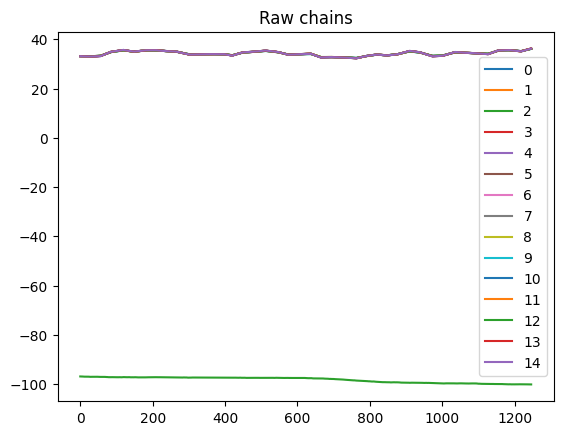

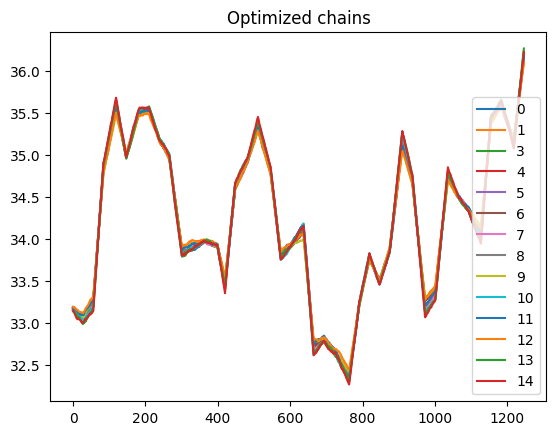

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.196  0.040   0.121    0.270      0.004    0.003     103.0     208.0   
eps    0.574  0.218   0.175    0.955      0.011    0.008     376.0    2557.0   
p_out  0.092  0.060   0.003    0.201      0.000    0.000   16177.0   17589.0   

       r_hat  
sig     1.10  
eps     1.03  
p_out   1.00  


In [30]:
selected_chains = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
remove_those = [2]
for i in remove_those:
    selected_chains.remove(i)


snc_ar1_nuts.visualize_latents(selected_chains)
snc_ar1_nuts.predict(selected_chains)

In [31]:
sub_data['muX'] = snc_ar1_nuts.muX
sub_data['ICL'] = snc_ar1_nuts.CIL
sub_data['ICU'] = snc_ar1_nuts.CIU
sub_data['pout'] = snc_ar1_nuts.pointwise_pout

sub_data.obs = np.log10(np.exp(sub_data.obs))
sub_data.muX = np.log10(np.exp(sub_data.muX))
sub_data.ICL = np.log10(np.exp(sub_data.ICL))
sub_data.ICU = np.log10(np.exp(sub_data.ICU))

RW2s[this_molecule] = sub_data.copy()

In [32]:
with plt.style.context(['science', 'notebook', 'grid']):

    LABEL_SIZE = 30
    TICK_SIZE = 30
    TITLE_SIZE = 38
    LEGEND_SIZE = 30
    DATES_SIZE = 18
    figsize = (28, 10) #figsize = (32, 10)
    
    plt.rc('axes', labelsize=LABEL_SIZE)
    plt.rc('xtick', labelsize=TICK_SIZE)   
    plt.rc('ytick', labelsize=TICK_SIZE)
    plt.rc('figure', titlesize=TITLE_SIZE)
    plt.rc('legend', fontsize=LEGEND_SIZE)
    plt.rcParams['text.usetex'] = True
    
    fig = plt.figure(figsize=figsize, layout="constrained")
    
    ax_dict = fig.subplot_mosaic(
        """
        A
        """
    )
    
    ### A
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.muX.values, label='$X^*_{t_{opt}}$', color='green', linewidth=8, zorder=3)
    
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICL.values, label='95% CI', linestyle='--', color='green', linewidth=5, zorder=1)
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICU.values, linestyle='--', color='green', linewidth=5, zorder=1)
    
    ax_dict['A'].fill_between(sub_data.dateStart.values, sub_data.ICL.values, sub_data.ICU.values, alpha=.3, color='green')

    
    scatter_points = ax_dict['A'].scatter(sub_data.dateStart.values, sub_data.obs.values, label='$\hat{X}_t$', 
                         c=sub_data.pout.values,
                         cmap='bwr', edgecolor='black', s=360, zorder=3,
                         linewidths=1.5, alpha=0.9, vmin=0, vmax=1)

    
    ax_dict['A'].set_ylabel("obs (ng) - $\log_{10}$ scale")
    ax_dict['A'].set_xlabel("Sampling date")
    ax_dict['A'].tick_params(axis='x', labelsize=TICK_SIZE)
    ax_dict['A'].tick_params(axis='y', labelsize=TICK_SIZE)
    ax_dict['A'].grid(linewidth=1, color='black', alpha=0.8)
    ax_dict['A'].set_title(this_molecule, size=TITLE_SIZE)

    ### Outlier probability legend:
    cmin, cmax = 0.0, 1.0 
    axins1 = inset_axes(ax_dict['A'], width='2%', height='100%', loc='right', borderpad=0)
    axins1.grid(False)
    cbar = fig.colorbar(scatter_points, cax=axins1, orientation='vertical')
    
    # Setting tick limits:
    cbar.set_ticks([cmin, cmax])
    cbar.ax.yaxis.set_major_locator(ticker.FixedLocator([cmin, cmax]))
    
    # Standardizing the float format displayed:
    decimal_places = 1
    cbar.ax.set_yticklabels([f"{cmin:.{decimal_places}f}", f"{cmax:.{decimal_places}f}"], fontsize=TICK_SIZE)

    # Placing the label at the right spot:
    cbar.ax.set_ylabel('Outlier probability', size=TICK_SIZE, labelpad=-35)

    # Main legend
    plt.rcParams['text.usetex'] = False
    h1, l1 = ax_dict['A'].get_legend_handles_labels()
    fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=5)
    
    plt.show()

In [33]:
### Pout estimé par le SCOU NUTS

In [34]:
for molecule in list(RW2s.keys()):
    this_file = RW2s[molecule]
    this_file.to_csv('../outputs/files/viral_data_manuscript/' + molecule + '.csv', sep=';', index=False)

In [35]:
this_molecule = 'Aichi virus A'
this_lod = 4500
this_lod

4500

In [36]:
sub_data = preprocess_data(this_molecule, this_lod)

In [37]:
sub_data.loc[sub_data.obs <= sub_data.lod]

dateStart        obs  Raw_lod  Raw_concentration        lod  \
693  2023-06-13  28.720128   4500.0             4500.0  28.720128   
875  2023-12-12  28.913866   4500.0             4500.0  28.913866   
938  2024-02-13  28.641490   4500.0             4500.0  28.641490   
1036 2024-05-21  29.158805   4500.0             4500.0  29.158805   

       plantVolume  
693   6.603600e+08  
875   8.015300e+08  
938   6.104200e+08  
1036  1.023990e+09

In [38]:
lod_matrix = sub_data.lod.values
observation_matrix = sub_data.obs.values

filename = 'discard.nc'
tuning_iters = 12000
sampling_iters = 2000
nb_chains = 15

snc_ar1_nuts = SCOU_RW1_NUTS(observation_matrix, lod_matrix, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=filename, 
                             p_out_frozen=-1, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
snc_ar1_nuts.fit()

# Done
notify_mac("Jupyter", "Work done !")

/opt/anaconda3/envs/pymc5/lib/python3.9/site-packages/pymc/distributions/timeseries.py:558: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (15 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 15 chains for 12_000 tune and 2_000 draw iterations (180_000 + 30_000 draws total) took 4373 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 4 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 6 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameteriz

Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.299  0.398   0.065    1.036      0.097    0.070      22.0      22.0   
eps    0.484  0.667   0.106    0.925      0.048    0.034     138.0      85.0   
p_out  0.289  0.268   0.033    0.872      0.064    0.047      33.0      71.0   

       r_hat  
sig     1.88  
eps     1.07  
p_out   1.37  


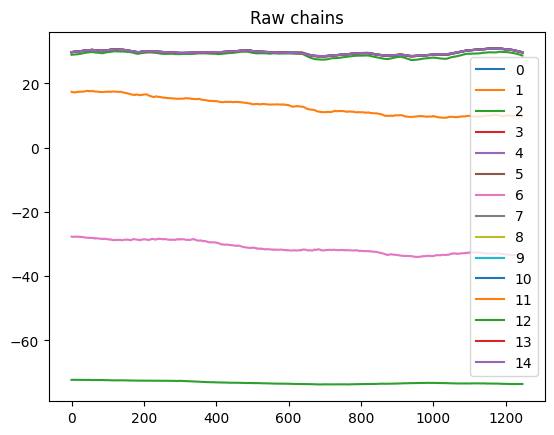

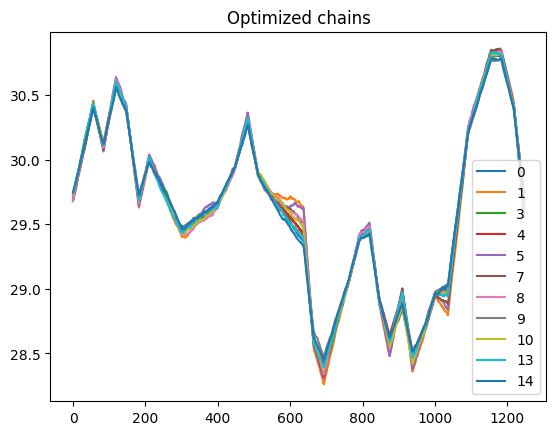

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.147  0.039   0.084    0.222      0.006    0.005      38.0      72.0   
eps    0.390  0.164   0.131    0.695      0.003    0.002    3440.0   11190.0   
p_out  0.168  0.082   0.032    0.321      0.001    0.001   12933.0   13645.0   

       r_hat  
sig     1.23  
eps     1.00  
p_out   1.00  


In [44]:
selected_chains = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
remove_those = [11, 2, 6, 12]
for i in remove_those:
    selected_chains.remove(i)


snc_ar1_nuts.visualize_latents(selected_chains)
snc_ar1_nuts.predict(selected_chains)

In [45]:
sub_data['muX'] = snc_ar1_nuts.muX
sub_data['ICL'] = snc_ar1_nuts.CIL
sub_data['ICU'] = snc_ar1_nuts.CIU
sub_data['pout'] = snc_ar1_nuts.pointwise_pout

sub_data.obs = np.log10(np.exp(sub_data.obs))
sub_data.muX = np.log10(np.exp(sub_data.muX))
sub_data.ICL = np.log10(np.exp(sub_data.ICL))
sub_data.ICU = np.log10(np.exp(sub_data.ICU))

RW2s[this_molecule] = sub_data.copy()

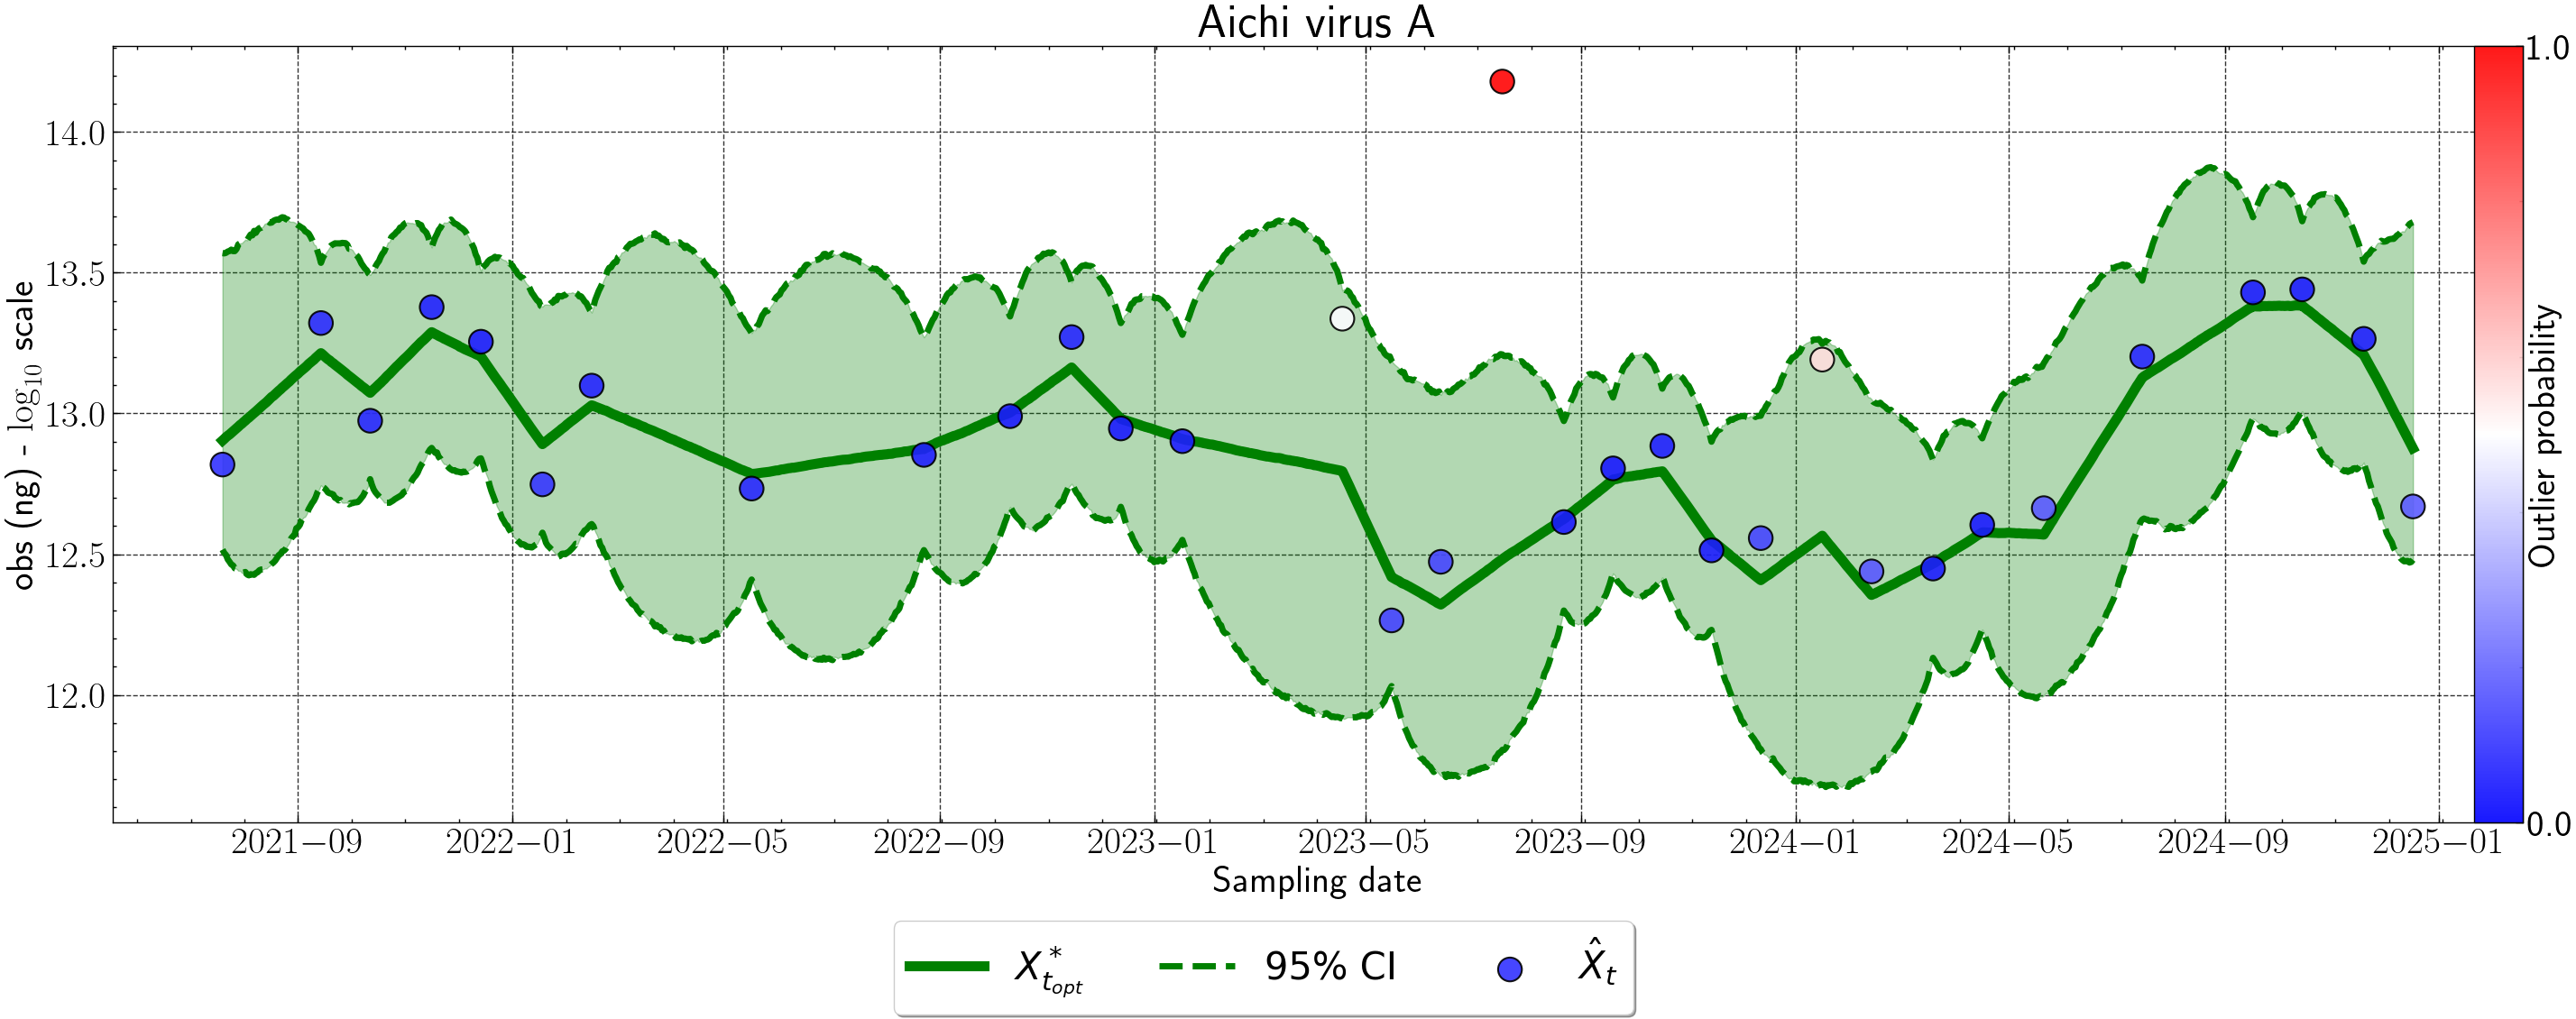

In [46]:
with plt.style.context(['science', 'notebook', 'grid']):

    LABEL_SIZE = 30
    TICK_SIZE = 30
    TITLE_SIZE = 38
    LEGEND_SIZE = 30
    DATES_SIZE = 18
    figsize = (28, 10) #figsize = (32, 10)
    
    plt.rc('axes', labelsize=LABEL_SIZE)
    plt.rc('xtick', labelsize=TICK_SIZE)   
    plt.rc('ytick', labelsize=TICK_SIZE)
    plt.rc('figure', titlesize=TITLE_SIZE)
    plt.rc('legend', fontsize=LEGEND_SIZE)
    plt.rcParams['text.usetex'] = True
    
    fig = plt.figure(figsize=figsize, layout="constrained")
    
    ax_dict = fig.subplot_mosaic(
        """
        A
        """
    )
    
    ### A
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.muX.values, label='$X^*_{t_{opt}}$', color='green', linewidth=8, zorder=3)
    
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICL.values, label='95% CI', linestyle='--', color='green', linewidth=5, zorder=1)
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICU.values, linestyle='--', color='green', linewidth=5, zorder=1)
    
    ax_dict['A'].fill_between(sub_data.dateStart.values, sub_data.ICL.values, sub_data.ICU.values, alpha=.3, color='green')

    
    scatter_points = ax_dict['A'].scatter(sub_data.dateStart.values, sub_data.obs.values, label='$\hat{X}_t$', 
                         c=sub_data.pout.values,
                         cmap='bwr', edgecolor='black', s=360, zorder=3,
                         linewidths=1.5, alpha=0.9, vmin=0, vmax=1)

    
    ax_dict['A'].set_ylabel("obs (ng) - $\log_{10}$ scale")
    ax_dict['A'].set_xlabel("Sampling date")
    ax_dict['A'].tick_params(axis='x', labelsize=TICK_SIZE)
    ax_dict['A'].tick_params(axis='y', labelsize=TICK_SIZE)
    ax_dict['A'].grid(linewidth=1, color='black', alpha=0.8)
    ax_dict['A'].set_title(this_molecule, size=TITLE_SIZE)

    ### Outlier probability legend:
    cmin, cmax = 0.0, 1.0 
    axins1 = inset_axes(ax_dict['A'], width='2%', height='100%', loc='right', borderpad=0)
    axins1.grid(False)
    cbar = fig.colorbar(scatter_points, cax=axins1, orientation='vertical')
    
    # Setting tick limits:
    cbar.set_ticks([cmin, cmax])
    cbar.ax.yaxis.set_major_locator(ticker.FixedLocator([cmin, cmax]))
    
    # Standardizing the float format displayed:
    decimal_places = 1
    cbar.ax.set_yticklabels([f"{cmin:.{decimal_places}f}", f"{cmax:.{decimal_places}f}"], fontsize=TICK_SIZE)

    # Placing the label at the right spot:
    cbar.ax.set_ylabel('Outlier probability', size=TICK_SIZE, labelpad=-35)

    # Main legend
    plt.rcParams['text.usetex'] = False
    h1, l1 = ax_dict['A'].get_legend_handles_labels()
    fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=5)
    
    plt.show()

In [47]:
### Pout estimé par le SCOU NUTS

In [48]:
for molecule in list(RW2s.keys()):
    this_file = RW2s[molecule]
    this_file.to_csv('../outputs/files/viral_data_manuscript/' + molecule + '.csv', sep=';', index=False)

In [61]:
this_molecule = 'enterovirus (ABCD)'
this_lod = 4500
this_lod

4500

In [62]:
sub_data = preprocess_data(this_molecule, this_lod)

In [63]:
sub_data.loc[sub_data.obs <= sub_data.lod]

dateStart        obs  Raw_lod  Raw_concentration        lod  plantVolume
875 2023-12-12  28.913866   4500.0             4500.0  28.913866  801530000.0
910 2024-01-16  28.645499   4500.0             4500.0  28.645499  612872000.0

In [64]:
lod_matrix = sub_data.lod.values
observation_matrix = sub_data.obs.values

filename = 'discard.nc'
tuning_iters = 12000
sampling_iters = 2000
nb_chains = 15

snc_ar1_nuts = SCOU_RW1_NUTS(observation_matrix, lod_matrix, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=filename, 
                             p_out_frozen=-1, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
snc_ar1_nuts.fit()

# Done
notify_mac("Jupyter", "Work done !")

/opt/anaconda3/envs/pymc5/lib/python3.9/site-packages/pymc/distributions/timeseries.py:558: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (15 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 15 chains for 12_000 tune and 2_000 draw iterations (180_000 + 30_000 draws total) took 4255 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 5 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 7 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 13 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameteri

Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.294  0.318   0.071    0.941      0.074    0.053      24.0      42.0   
eps    0.627  0.890   0.121    1.057      0.046    0.033     322.0     103.0   
p_out  0.302  0.317   0.025    0.914      0.080    0.058      29.0      94.0   

       r_hat  
sig     1.72  
eps     1.07  
p_out   1.46  


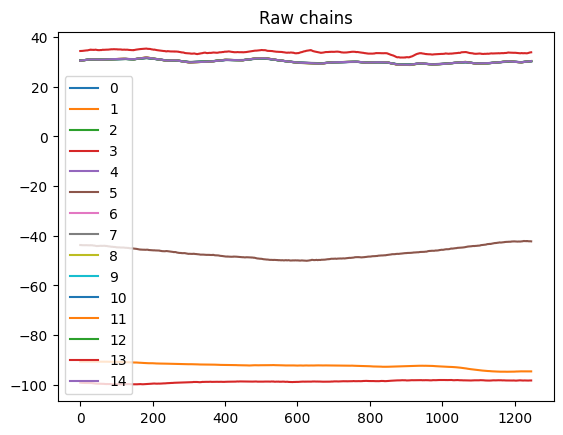

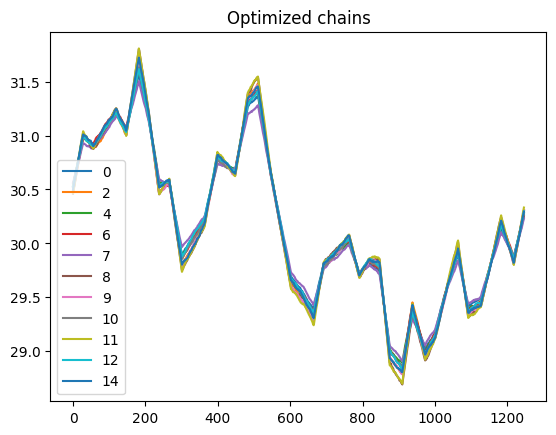

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.140  0.033   0.084    0.202      0.004    0.003      74.0     286.0   
eps    0.519  0.177   0.183    0.828      0.007    0.005     563.0    2954.0   
p_out  0.131  0.070   0.021    0.263      0.001    0.000   16163.0   13527.0   

       r_hat  
sig     1.13  
eps     1.02  
p_out   1.00  


In [69]:
selected_chains = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
remove_those = [3, 13, 1, 5]
for i in remove_those:
    selected_chains.remove(i)


snc_ar1_nuts.visualize_latents(selected_chains)
snc_ar1_nuts.predict(selected_chains)

In [70]:
sub_data['muX'] = snc_ar1_nuts.muX
sub_data['ICL'] = snc_ar1_nuts.CIL
sub_data['ICU'] = snc_ar1_nuts.CIU
sub_data['pout'] = snc_ar1_nuts.pointwise_pout

sub_data.obs = np.log10(np.exp(sub_data.obs))
sub_data.muX = np.log10(np.exp(sub_data.muX))
sub_data.ICL = np.log10(np.exp(sub_data.ICL))
sub_data.ICU = np.log10(np.exp(sub_data.ICU))

RW2s[this_molecule] = sub_data.copy()

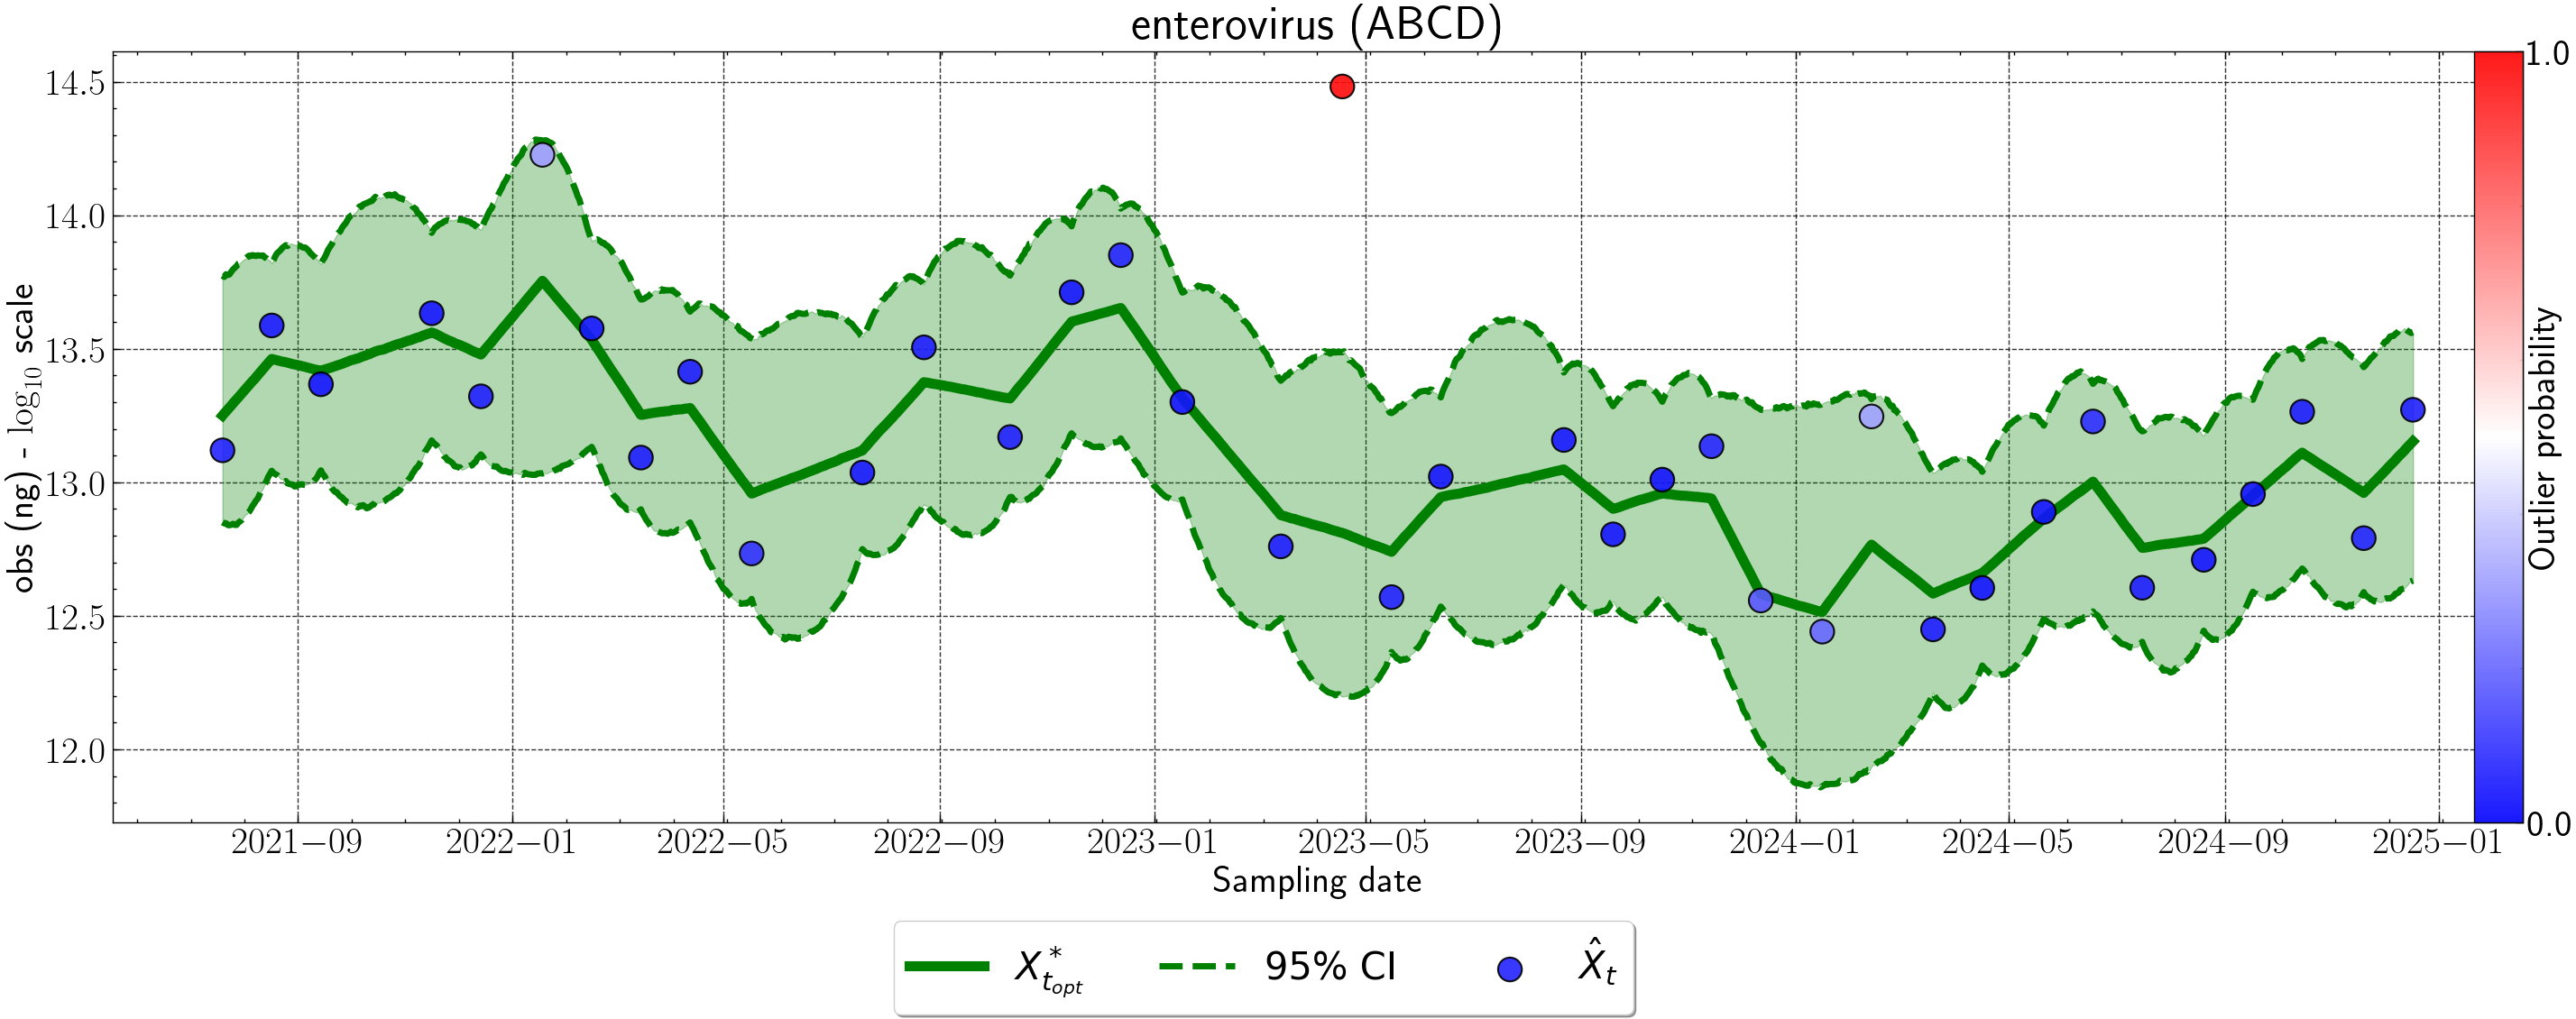

In [71]:
with plt.style.context(['science', 'notebook', 'grid']):

    LABEL_SIZE = 30
    TICK_SIZE = 30
    TITLE_SIZE = 38
    LEGEND_SIZE = 30
    DATES_SIZE = 18
    figsize = (28, 10) #figsize = (32, 10)
    
    plt.rc('axes', labelsize=LABEL_SIZE)
    plt.rc('xtick', labelsize=TICK_SIZE)   
    plt.rc('ytick', labelsize=TICK_SIZE)
    plt.rc('figure', titlesize=TITLE_SIZE)
    plt.rc('legend', fontsize=LEGEND_SIZE)
    plt.rcParams['text.usetex'] = True
    
    fig = plt.figure(figsize=figsize, layout="constrained")
    
    ax_dict = fig.subplot_mosaic(
        """
        A
        """
    )
    
    ### A
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.muX.values, label='$X^*_{t_{opt}}$', color='green', linewidth=8, zorder=3)
    
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICL.values, label='95% CI', linestyle='--', color='green', linewidth=5, zorder=1)
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICU.values, linestyle='--', color='green', linewidth=5, zorder=1)
    
    ax_dict['A'].fill_between(sub_data.dateStart.values, sub_data.ICL.values, sub_data.ICU.values, alpha=.3, color='green')

    
    scatter_points = ax_dict['A'].scatter(sub_data.dateStart.values, sub_data.obs.values, label='$\hat{X}_t$', 
                         c=sub_data.pout.values,
                         cmap='bwr', edgecolor='black', s=360, zorder=3,
                         linewidths=1.5, alpha=0.9, vmin=0, vmax=1)

    
    ax_dict['A'].set_ylabel("obs (ng) - $\log_{10}$ scale")
    ax_dict['A'].set_xlabel("Sampling date")
    ax_dict['A'].tick_params(axis='x', labelsize=TICK_SIZE)
    ax_dict['A'].tick_params(axis='y', labelsize=TICK_SIZE)
    ax_dict['A'].grid(linewidth=1, color='black', alpha=0.8)
    ax_dict['A'].set_title(this_molecule, size=TITLE_SIZE)

    ### Outlier probability legend:
    cmin, cmax = 0.0, 1.0 
    axins1 = inset_axes(ax_dict['A'], width='2%', height='100%', loc='right', borderpad=0)
    axins1.grid(False)
    cbar = fig.colorbar(scatter_points, cax=axins1, orientation='vertical')
    
    # Setting tick limits:
    cbar.set_ticks([cmin, cmax])
    cbar.ax.yaxis.set_major_locator(ticker.FixedLocator([cmin, cmax]))
    
    # Standardizing the float format displayed:
    decimal_places = 1
    cbar.ax.set_yticklabels([f"{cmin:.{decimal_places}f}", f"{cmax:.{decimal_places}f}"], fontsize=TICK_SIZE)

    # Placing the label at the right spot:
    cbar.ax.set_ylabel('Outlier probability', size=TICK_SIZE, labelpad=-35)

    # Main legend
    plt.rcParams['text.usetex'] = False
    h1, l1 = ax_dict['A'].get_legend_handles_labels()
    fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=5)
    
    plt.show()

In [72]:
### Pout estimé par le SCOU NUTS

In [73]:
for molecule in list(RW2s.keys()):
    this_file = RW2s[molecule]
    this_file.to_csv('../outputs/files/viral_data_manuscript/' + molecule + '.csv', sep=';', index=False)

In [74]:
this_molecule = 'SAPOVIRUS GI/GII/GIV'
this_lod = 4500
this_lod

4500

In [75]:
sub_data = preprocess_data(this_molecule, this_lod)

In [76]:
sub_data.loc[sub_data.obs <= sub_data.lod]

Empty DataFrame
Columns: [dateStart, obs, Raw_lod, Raw_concentration, lod, plantVolume]
Index: []

In [77]:
lod_matrix = sub_data.lod.values
observation_matrix = sub_data.obs.values

filename = 'discard.nc'
tuning_iters = 12000
sampling_iters = 2000
nb_chains = 15

snc_ar1_nuts = SCOU_RW1_NUTS(observation_matrix, lod_matrix, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=filename, 
                             p_out_frozen=-1, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
snc_ar1_nuts.fit()

# Done
notify_mac("Jupyter", "Work done !")

/opt/anaconda3/envs/pymc5/lib/python3.9/site-packages/pymc/distributions/timeseries.py:558: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (15 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 15 chains for 12_000 tune and 2_000 draw iterations (180_000 + 30_000 draws total) took 5775 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 6 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 8 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 9 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 10 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameteri

Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.228  0.237   0.070    0.435      0.049    0.035      32.0      20.0   
eps    0.876  0.450   0.233    1.400      0.016    0.011     230.0     559.0   
p_out  0.181  0.203   0.001    0.821      0.049    0.037      56.0      21.0   

       r_hat  
sig     1.41  
eps     1.04  
p_out   1.18  


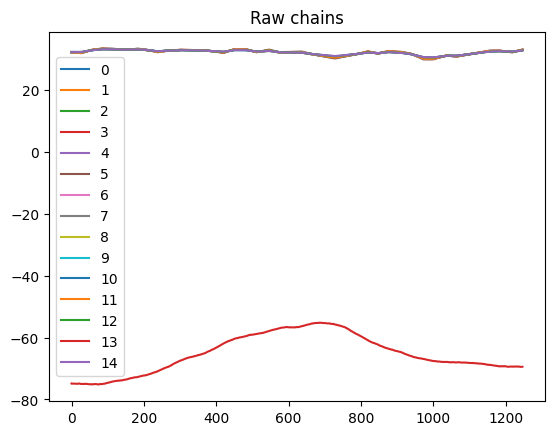

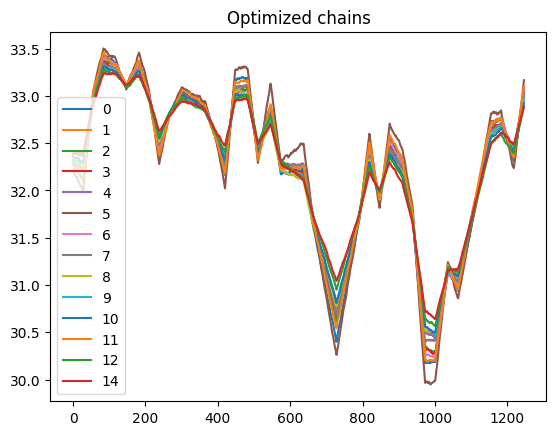

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.177  0.051   0.093    0.276      0.007    0.005      52.0     184.0   
eps    0.869  0.299   0.282    1.402      0.021    0.015     201.0    1435.0   
p_out  0.131  0.077   0.009    0.272      0.001    0.000   16274.0   17942.0   

       r_hat  
sig     1.20  
eps     1.05  
p_out   1.00  


In [80]:
selected_chains = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
remove_those = [13]
for i in remove_those:
    selected_chains.remove(i)


snc_ar1_nuts.visualize_latents(selected_chains)
snc_ar1_nuts.predict(selected_chains)

In [81]:
sub_data['muX'] = snc_ar1_nuts.muX
sub_data['ICL'] = snc_ar1_nuts.CIL
sub_data['ICU'] = snc_ar1_nuts.CIU
sub_data['pout'] = snc_ar1_nuts.pointwise_pout

sub_data.obs = np.log10(np.exp(sub_data.obs))
sub_data.muX = np.log10(np.exp(sub_data.muX))
sub_data.ICL = np.log10(np.exp(sub_data.ICL))
sub_data.ICU = np.log10(np.exp(sub_data.ICU))

RW2s[this_molecule] = sub_data.copy()

In [82]:
with plt.style.context(['science', 'notebook', 'grid']):

    LABEL_SIZE = 30
    TICK_SIZE = 30
    TITLE_SIZE = 38
    LEGEND_SIZE = 30
    DATES_SIZE = 18
    figsize = (28, 10) #figsize = (32, 10)
    
    plt.rc('axes', labelsize=LABEL_SIZE)
    plt.rc('xtick', labelsize=TICK_SIZE)   
    plt.rc('ytick', labelsize=TICK_SIZE)
    plt.rc('figure', titlesize=TITLE_SIZE)
    plt.rc('legend', fontsize=LEGEND_SIZE)
    plt.rcParams['text.usetex'] = True
    
    fig = plt.figure(figsize=figsize, layout="constrained")
    
    ax_dict = fig.subplot_mosaic(
        """
        A
        """
    )
    
    ### A
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.muX.values, label='$X^*_{t_{opt}}$', color='green', linewidth=8, zorder=3)
    
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICL.values, label='95% CI', linestyle='--', color='green', linewidth=5, zorder=1)
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICU.values, linestyle='--', color='green', linewidth=5, zorder=1)
    
    ax_dict['A'].fill_between(sub_data.dateStart.values, sub_data.ICL.values, sub_data.ICU.values, alpha=.3, color='green')

    
    scatter_points = ax_dict['A'].scatter(sub_data.dateStart.values, sub_data.obs.values, label='$\hat{X}_t$', 
                         c=sub_data.pout.values,
                         cmap='bwr', edgecolor='black', s=360, zorder=3,
                         linewidths=1.5, alpha=0.9, vmin=0, vmax=1)

    
    ax_dict['A'].set_ylabel("obs (ng) - $\log_{10}$ scale")
    ax_dict['A'].set_xlabel("Sampling date")
    ax_dict['A'].tick_params(axis='x', labelsize=TICK_SIZE)
    ax_dict['A'].tick_params(axis='y', labelsize=TICK_SIZE)
    ax_dict['A'].grid(linewidth=1, color='black', alpha=0.8)
    ax_dict['A'].set_title(this_molecule, size=TITLE_SIZE)

    ### Outlier probability legend:
    cmin, cmax = 0.0, 1.0 
    axins1 = inset_axes(ax_dict['A'], width='2%', height='100%', loc='right', borderpad=0)
    axins1.grid(False)
    cbar = fig.colorbar(scatter_points, cax=axins1, orientation='vertical')
    
    # Setting tick limits:
    cbar.set_ticks([cmin, cmax])
    cbar.ax.yaxis.set_major_locator(ticker.FixedLocator([cmin, cmax]))
    
    # Standardizing the float format displayed:
    decimal_places = 1
    cbar.ax.set_yticklabels([f"{cmin:.{decimal_places}f}", f"{cmax:.{decimal_places}f}"], fontsize=TICK_SIZE)

    # Placing the label at the right spot:
    cbar.ax.set_ylabel('Outlier probability', size=TICK_SIZE, labelpad=-35)

    # Main legend
    plt.rcParams['text.usetex'] = False
    h1, l1 = ax_dict['A'].get_legend_handles_labels()
    fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=5)
    
    plt.show()

In [83]:
### Pout estimé par le SCOU NUTS

In [88]:
for molecule in list(RW2s.keys()):
    this_file = RW2s[molecule]
    this_file.to_csv('../outputs/files/viral_data_manuscript/' + molecule + '.csv', sep=';', index=False)

In [112]:
this_molecule = 'SARS-Cov2 (UG Gene E/L)'
this_lod = 4500
this_lod

4500

In [113]:
sub_data = preprocess_data(this_molecule, this_lod)

In [114]:
sub_data.loc[sub_data.obs <= sub_data.lod]

dateStart        obs  Raw_lod  Raw_concentration        lod   plantVolume
490 2023-01-17  29.154578   4500.0             4500.0  29.154578  1.019670e+09

In [115]:
lod_matrix = sub_data.lod.values
observation_matrix = sub_data.obs.values

filename = 'discard.nc'
tuning_iters = 12000
sampling_iters = 2000
nb_chains = 15

snc_ar1_nuts = SCOU_RW1_NUTS(observation_matrix, lod_matrix, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=filename, 
                             p_out_frozen=-1, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
snc_ar1_nuts.fit()

# Done
notify_mac("Jupyter", "Work done !")

/opt/anaconda3/envs/pymc5/lib/python3.9/site-packages/pymc/distributions/timeseries.py:558: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (15 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 15 chains for 12_000 tune and 2_000 draw iterations (180_000 + 30_000 draws total) took 3942 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 10 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.201  0.083   0.095    0.295      0.018    0.013      40.0      19.0   
eps    0.586  0.368   0.162    0.995      0.021    0.015     490.0     248.0   
p_out  0.184  0.200   0.004    0.814      0.048    0.037      56.0      20.0   

       r_hat  
sig     1.31  
eps     1.03  
p_out   1.18  


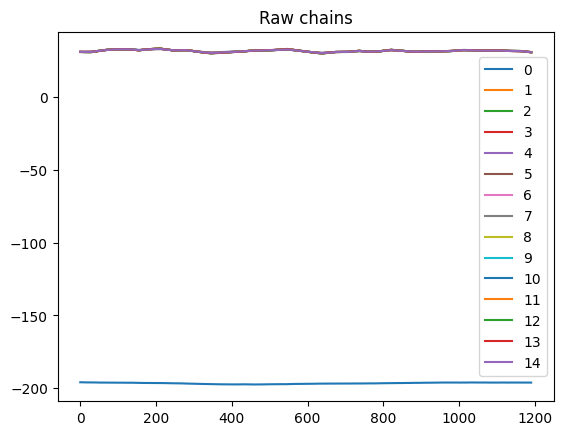

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.184  0.041   0.108    0.259      0.004    0.003      86.0     200.0   
eps    0.562  0.221   0.166    0.950      0.010    0.007     531.0    4072.0   
p_out  0.134  0.075   0.014    0.270      0.001    0.001    9201.0   19073.0   

       r_hat  
sig     1.13  
eps     1.02  
p_out   1.00  


In [118]:
selected_chains = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
remove_those = [10]
for i in remove_those:
    selected_chains.remove(i)


snc_ar1_nuts.visualize_latents(selected_chains)
snc_ar1_nuts.predict(selected_chains)

In [119]:
sub_data['muX'] = snc_ar1_nuts.muX
sub_data['ICL'] = snc_ar1_nuts.CIL
sub_data['ICU'] = snc_ar1_nuts.CIU
sub_data['pout'] = snc_ar1_nuts.pointwise_pout

sub_data.obs = np.log10(np.exp(sub_data.obs))
sub_data.muX = np.log10(np.exp(sub_data.muX))
sub_data.ICL = np.log10(np.exp(sub_data.ICL))
sub_data.ICU = np.log10(np.exp(sub_data.ICU))

RW2s[this_molecule] = sub_data.copy()

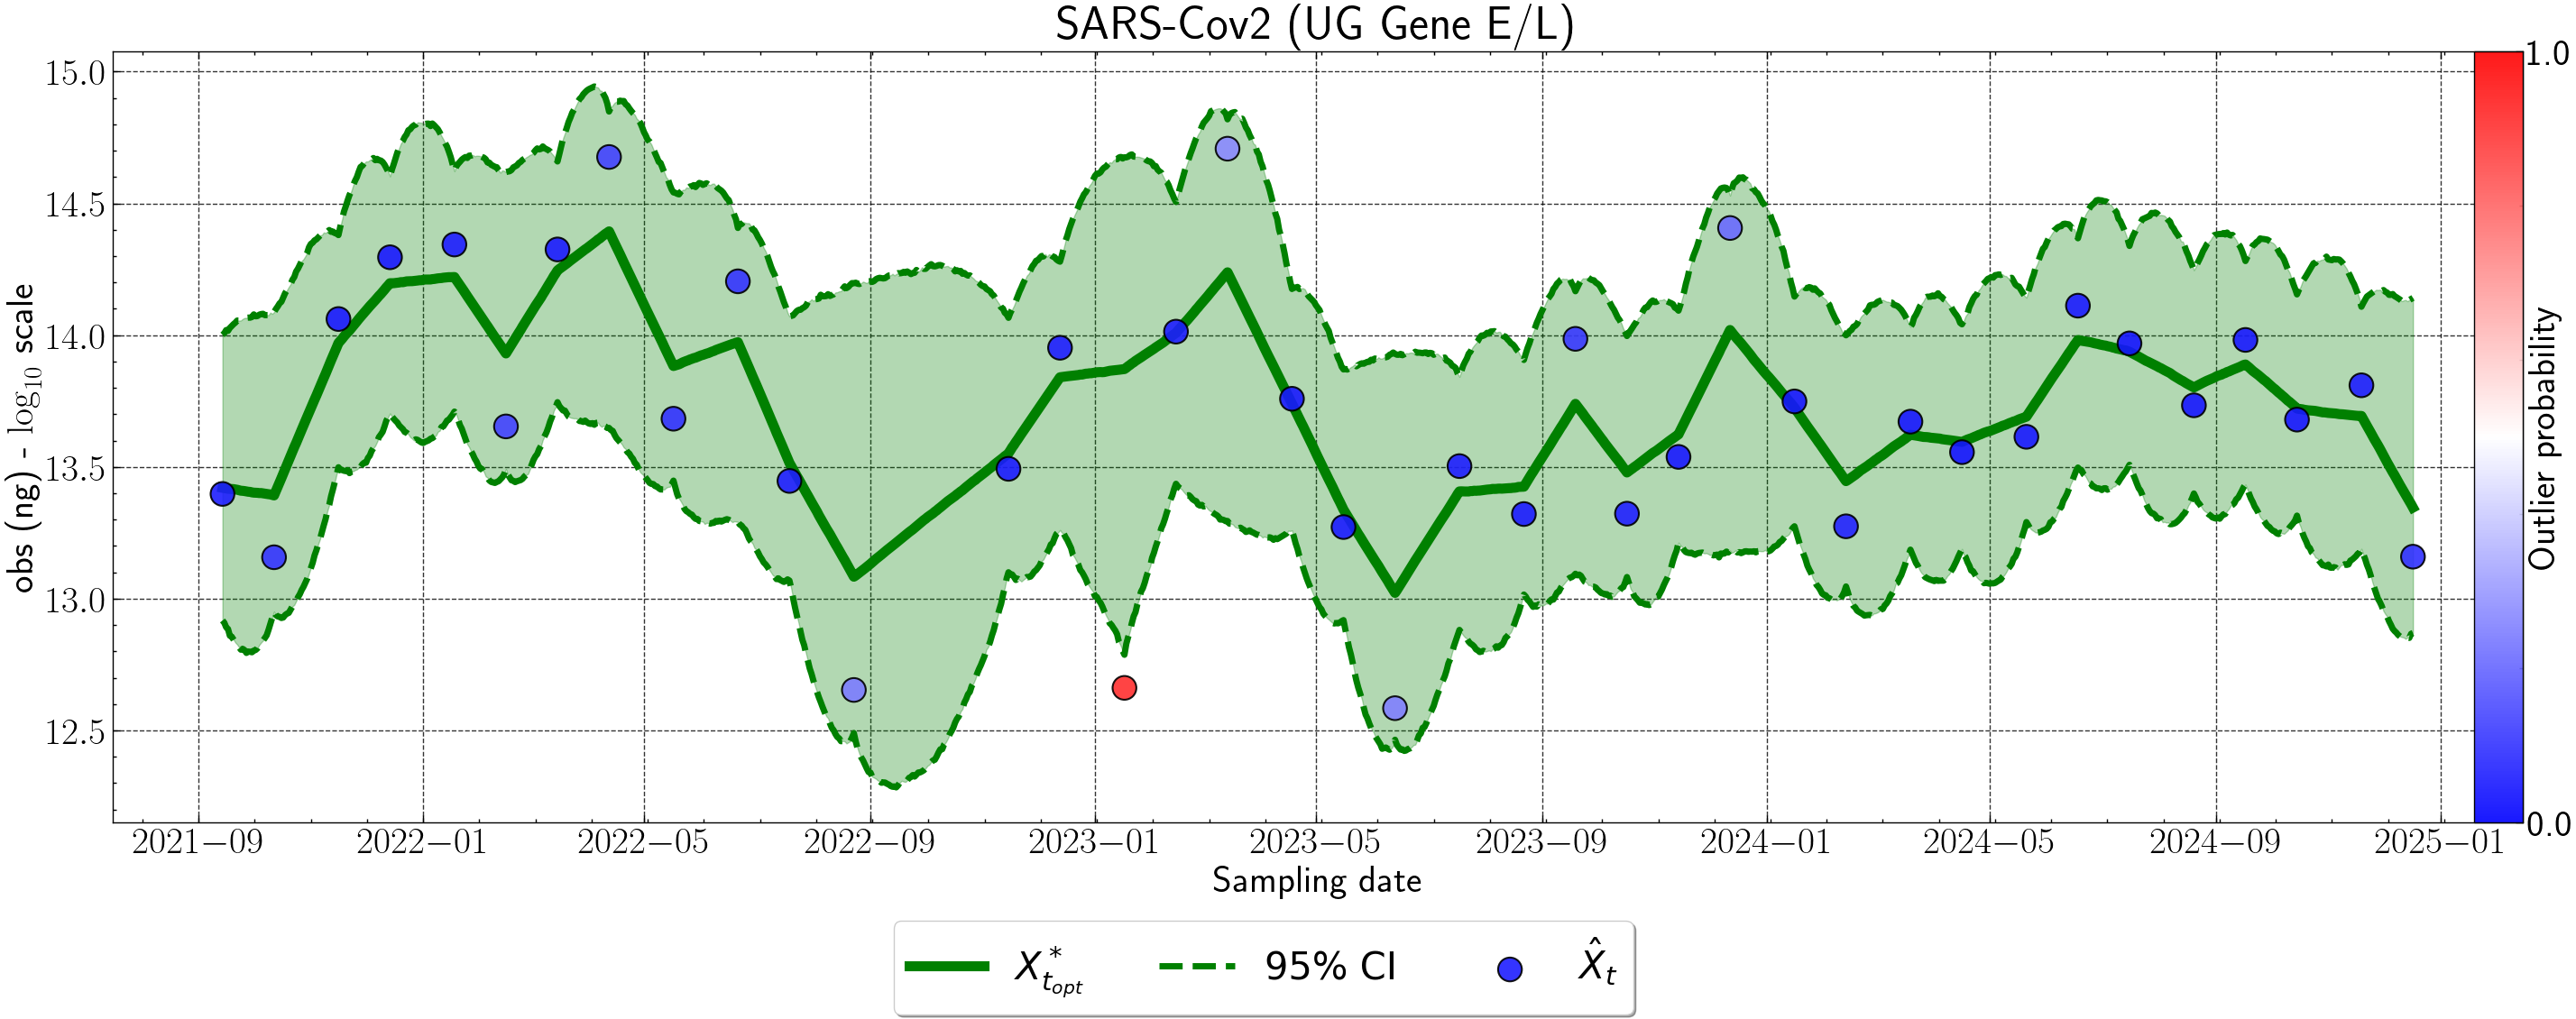

In [120]:
with plt.style.context(['science', 'notebook', 'grid']):

    LABEL_SIZE = 30
    TICK_SIZE = 30
    TITLE_SIZE = 38
    LEGEND_SIZE = 30
    DATES_SIZE = 18
    figsize = (28, 10) #figsize = (32, 10)
    
    plt.rc('axes', labelsize=LABEL_SIZE)
    plt.rc('xtick', labelsize=TICK_SIZE)   
    plt.rc('ytick', labelsize=TICK_SIZE)
    plt.rc('figure', titlesize=TITLE_SIZE)
    plt.rc('legend', fontsize=LEGEND_SIZE)
    plt.rcParams['text.usetex'] = True
    
    fig = plt.figure(figsize=figsize, layout="constrained")
    
    ax_dict = fig.subplot_mosaic(
        """
        A
        """
    )
    
    ### A
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.muX.values, label='$X^*_{t_{opt}}$', color='green', linewidth=8, zorder=3)
    
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICL.values, label='95% CI', linestyle='--', color='green', linewidth=5, zorder=1)
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICU.values, linestyle='--', color='green', linewidth=5, zorder=1)
    
    ax_dict['A'].fill_between(sub_data.dateStart.values, sub_data.ICL.values, sub_data.ICU.values, alpha=.3, color='green')

    
    scatter_points = ax_dict['A'].scatter(sub_data.dateStart.values, sub_data.obs.values, label='$\hat{X}_t$', 
                         c=sub_data.pout.values,
                         cmap='bwr', edgecolor='black', s=360, zorder=3,
                         linewidths=1.5, alpha=0.9, vmin=0, vmax=1)

    
    ax_dict['A'].set_ylabel("obs (ng) - $\log_{10}$ scale")
    ax_dict['A'].set_xlabel("Sampling date")
    ax_dict['A'].tick_params(axis='x', labelsize=TICK_SIZE)
    ax_dict['A'].tick_params(axis='y', labelsize=TICK_SIZE)
    ax_dict['A'].grid(linewidth=1, color='black', alpha=0.8)
    ax_dict['A'].set_title(this_molecule, size=TITLE_SIZE)

    ### Outlier probability legend:
    cmin, cmax = 0.0, 1.0 
    axins1 = inset_axes(ax_dict['A'], width='2%', height='100%', loc='right', borderpad=0)
    axins1.grid(False)
    cbar = fig.colorbar(scatter_points, cax=axins1, orientation='vertical')
    
    # Setting tick limits:
    cbar.set_ticks([cmin, cmax])
    cbar.ax.yaxis.set_major_locator(ticker.FixedLocator([cmin, cmax]))
    
    # Standardizing the float format displayed:
    decimal_places = 1
    cbar.ax.set_yticklabels([f"{cmin:.{decimal_places}f}", f"{cmax:.{decimal_places}f}"], fontsize=TICK_SIZE)

    # Placing the label at the right spot:
    cbar.ax.set_ylabel('Outlier probability', size=TICK_SIZE, labelpad=-35)

    # Main legend
    plt.rcParams['text.usetex'] = False
    h1, l1 = ax_dict['A'].get_legend_handles_labels()
    fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=5)
    
    plt.show()

In [121]:
### Pout estimé par le SCOU NUTS

In [123]:
molecule

'SAPOVIRUS GI/GII/GIV'

In [132]:
for molecule in list(RW2s.keys()):
    this_file = RW2s[molecule]
    if molecule=='SAPOVIRUS GI/GII/GIV':
        tm = 'SAPOVIRUS'
    elif molecule=='SARS-Cov2 (UG Gene E/L)':
        tm = 'SARS-CoV-2'
    else:
        tm = molecule
    this_file.to_csv('../outputs/files/viral_data_manuscript/' + tm + '.csv', sep=';', index=False)

In [138]:
this_molecule = 'Rotavirus G1P[8], G2P[4], G3P[8], G4P[8], G9P[8] et G12P[8] (8G12)'
this_lod = 4500
this_lod

4500

In [139]:
sub_data = preprocess_data(this_molecule, this_lod)

In [140]:
sub_data.loc[sub_data.obs <= sub_data.lod]

Empty DataFrame
Columns: [dateStart, obs, Raw_lod, Raw_concentration, lod, plantVolume]
Index: []

In [142]:
lod_matrix = sub_data.lod.values
observation_matrix = sub_data.obs.values

filename = 'discard.nc'
tuning_iters = 12000
sampling_iters = 2000
nb_chains = 15

snc_ar1_nuts = SCOU_RW1_NUTS(observation_matrix, lod_matrix, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=filename, 
                             p_out_frozen=-1, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
snc_ar1_nuts.fit()

# Done
notify_mac("Jupyter", "Work done !")

/opt/anaconda3/envs/pymc5/lib/python3.9/site-packages/pymc/distributions/timeseries.py:558: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (15 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 15 chains for 12_000 tune and 2_000 draw iterations (180_000 + 30_000 draws total) took 4459 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 4 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 5 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 6 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 7 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameteriz

Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.247  0.085   0.095    0.407      0.013    0.010      38.0      92.0   
eps    1.353  0.498   0.315    2.143      0.032    0.022     249.0    1783.0   
p_out  0.132  0.088   0.006    0.296      0.001    0.001    9026.0   10702.0   

       r_hat  
sig     1.33  
eps     1.04  
p_out   1.00  


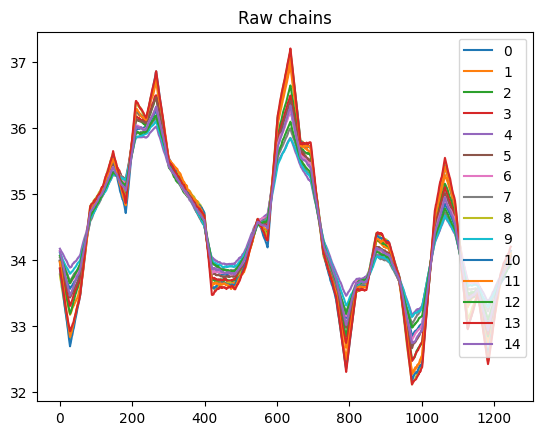

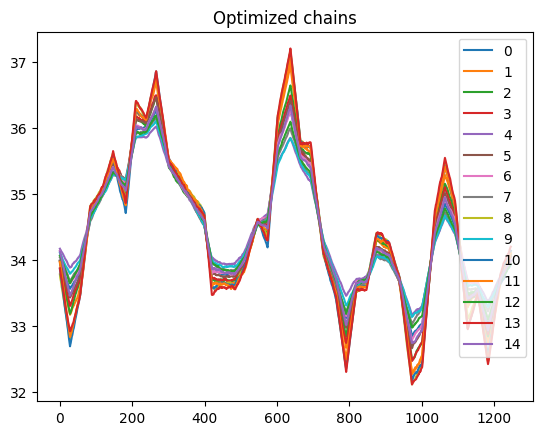

Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.247  0.085   0.095    0.407      0.013    0.010      38.0      92.0   
eps    1.353  0.498   0.315    2.143      0.032    0.022     249.0    1783.0   
p_out  0.132  0.088   0.006    0.296      0.001    0.001    9026.0   10702.0   

       r_hat  
sig     1.33  
eps     1.04  
p_out   1.00  


In [144]:
selected_chains = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
remove_those = []
for i in remove_those:
    selected_chains.remove(i)


snc_ar1_nuts.visualize_latents(selected_chains)
snc_ar1_nuts.predict(selected_chains)

In [145]:
sub_data['muX'] = snc_ar1_nuts.muX
sub_data['ICL'] = snc_ar1_nuts.CIL
sub_data['ICU'] = snc_ar1_nuts.CIU
sub_data['pout'] = snc_ar1_nuts.pointwise_pout

sub_data.obs = np.log10(np.exp(sub_data.obs))
sub_data.muX = np.log10(np.exp(sub_data.muX))
sub_data.ICL = np.log10(np.exp(sub_data.ICL))
sub_data.ICU = np.log10(np.exp(sub_data.ICU))

RW2s[this_molecule] = sub_data.copy()

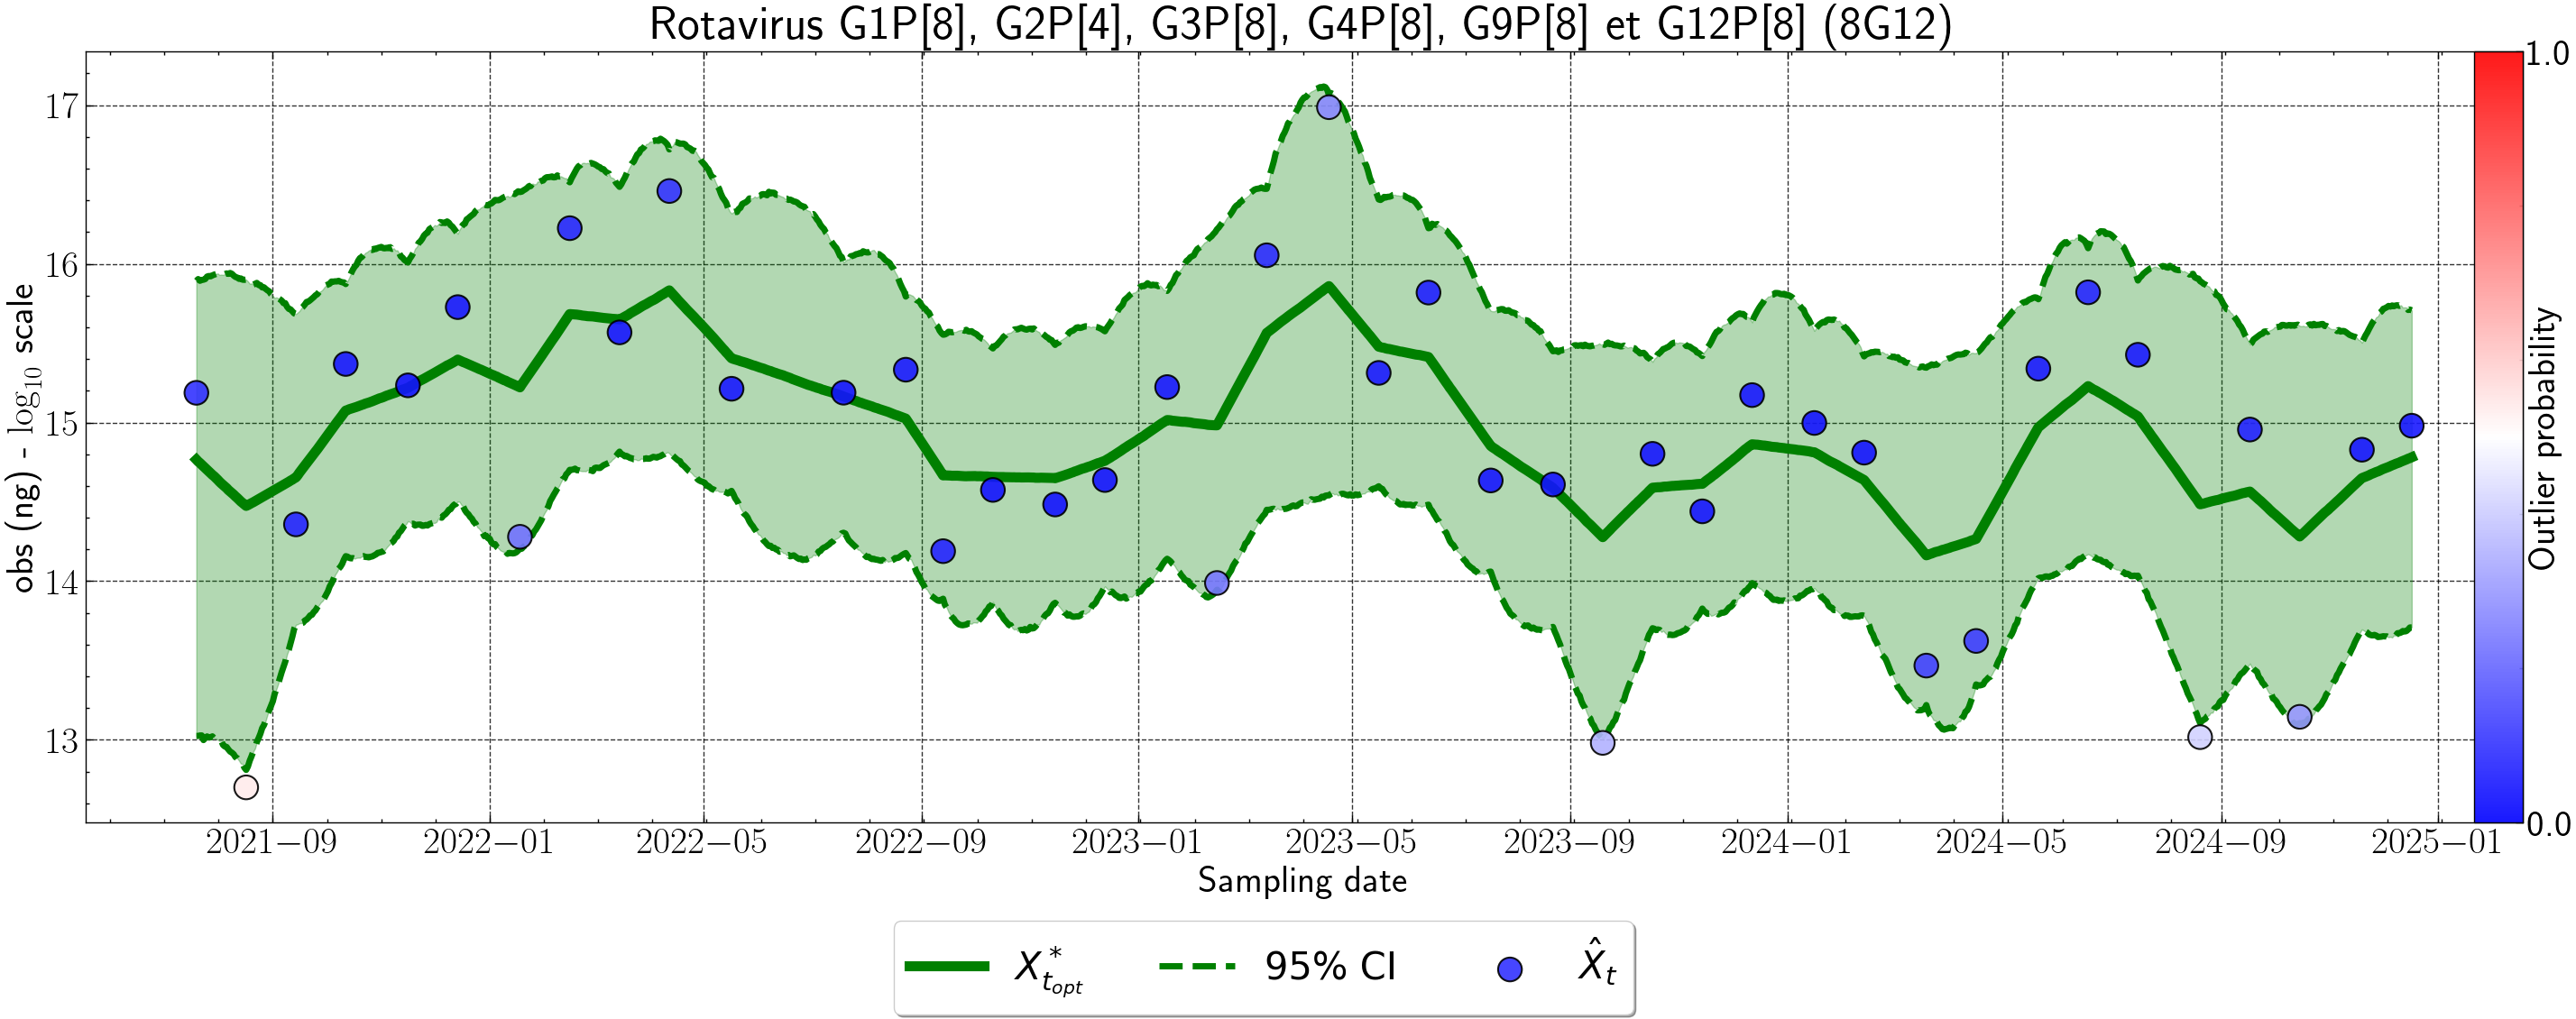

In [146]:
with plt.style.context(['science', 'notebook', 'grid']):

    LABEL_SIZE = 30
    TICK_SIZE = 30
    TITLE_SIZE = 38
    LEGEND_SIZE = 30
    DATES_SIZE = 18
    figsize = (28, 10) #figsize = (32, 10)
    
    plt.rc('axes', labelsize=LABEL_SIZE)
    plt.rc('xtick', labelsize=TICK_SIZE)   
    plt.rc('ytick', labelsize=TICK_SIZE)
    plt.rc('figure', titlesize=TITLE_SIZE)
    plt.rc('legend', fontsize=LEGEND_SIZE)
    plt.rcParams['text.usetex'] = True
    
    fig = plt.figure(figsize=figsize, layout="constrained")
    
    ax_dict = fig.subplot_mosaic(
        """
        A
        """
    )
    
    ### A
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.muX.values, label='$X^*_{t_{opt}}$', color='green', linewidth=8, zorder=3)
    
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICL.values, label='95% CI', linestyle='--', color='green', linewidth=5, zorder=1)
    ax_dict['A'].plot(sub_data.dateStart.values, sub_data.ICU.values, linestyle='--', color='green', linewidth=5, zorder=1)
    
    ax_dict['A'].fill_between(sub_data.dateStart.values, sub_data.ICL.values, sub_data.ICU.values, alpha=.3, color='green')

    
    scatter_points = ax_dict['A'].scatter(sub_data.dateStart.values, sub_data.obs.values, label='$\hat{X}_t$', 
                         c=sub_data.pout.values,
                         cmap='bwr', edgecolor='black', s=360, zorder=3,
                         linewidths=1.5, alpha=0.9, vmin=0, vmax=1)

    
    ax_dict['A'].set_ylabel("obs (ng) - $\log_{10}$ scale")
    ax_dict['A'].set_xlabel("Sampling date")
    ax_dict['A'].tick_params(axis='x', labelsize=TICK_SIZE)
    ax_dict['A'].tick_params(axis='y', labelsize=TICK_SIZE)
    ax_dict['A'].grid(linewidth=1, color='black', alpha=0.8)
    ax_dict['A'].set_title(this_molecule, size=TITLE_SIZE)

    ### Outlier probability legend:
    cmin, cmax = 0.0, 1.0 
    axins1 = inset_axes(ax_dict['A'], width='2%', height='100%', loc='right', borderpad=0)
    axins1.grid(False)
    cbar = fig.colorbar(scatter_points, cax=axins1, orientation='vertical')
    
    # Setting tick limits:
    cbar.set_ticks([cmin, cmax])
    cbar.ax.yaxis.set_major_locator(ticker.FixedLocator([cmin, cmax]))
    
    # Standardizing the float format displayed:
    decimal_places = 1
    cbar.ax.set_yticklabels([f"{cmin:.{decimal_places}f}", f"{cmax:.{decimal_places}f}"], fontsize=TICK_SIZE)

    # Placing the label at the right spot:
    cbar.ax.set_ylabel('Outlier probability', size=TICK_SIZE, labelpad=-35)

    # Main legend
    plt.rcParams['text.usetex'] = False
    h1, l1 = ax_dict['A'].get_legend_handles_labels()
    fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=5)
    
    plt.show()

In [147]:
### Pout estimé par le SCOU NUTS

In [148]:
molecule

'SARS-Cov2 (UG Gene E/L)'

In [149]:
for molecule in list(RW2s.keys()):
    this_file = RW2s[molecule]
    if molecule=='SAPOVIRUS GI/GII/GIV':
        tm = 'SAPOVIRUS'
    elif molecule=='SARS-Cov2 (UG Gene E/L)':
        tm = 'SARS-CoV-2'
    else:
        tm = molecule
    this_file.to_csv('../outputs/files/viral_data_manuscript/' + tm + '.csv', sep=';', index=False)